# Signal quality metrics and channel rejection

This work is based on the excellent tutorials created by the MNE and MNE-NIRS developers:

- **MNE**: [Tutorials](https://mne.tools/stable/auto_tutorials/index.html)
- **MNE-NIRS**: [Examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html)


## Table of Contents
* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
    * [Visual inspection](#section_1_3)
        * [Physiological noise](#sub_section_1_3_1)
        * [Spikes](#sub_section_1_3_2)
        * [Baseline shifts](#sub_section_1_3_3)
        * [Baseline drift](#sub_section_1_3_4)
    * [Signal quality metrics and channel rejection](#section_1_4)
        * [Scalp Coupling Index](#sub_section_1_4_2)
        * [Peak Spectral Power](#sub_section_1_4_3)

## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [1]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_nirs
import pywt
import scipy
import dabest
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression
from mne.preprocessing import ICA, corrmap
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr
from scipy.signal import wiener
from scipy.interpolate import CubicSpline
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import dataframe_image as dfi
import pathlib

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\fabia\AppData\Local\Temp\ipykernel_6028\1032699332.py:22: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Write own functions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw

def add_info2(raw_intensity, first_name, last_name, age, sex, EHI):
    """
    Input: raw object, first name, last name, age, sex, EHI
    Function: Returns raw object with added subject info
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    return raw

def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        %matplotlib inline
        gyro_data.plot(title='Gyroscope data', grid = True, xlabel = 'samples', ylabel = 'dps')
        acc_data.plot(title='Accelerometer data', grid = True, xlabel = 'samples', ylabel = 'm/s^2')

    return IMU_data, acc_data, gyro_data

def plot_SNR(raw, scores, times, threshold=0.1):
    """
    Plot time x channel based quality metrics.

    The left figure shows the raw score per channel and time.

    Parameters
    ----------
    raw : instance of Raw
        The haemoglobin data.
    scores : array
        The quality metric scores.
    times : list of pairs
        Start and end time for each quality metric.
    threshold : float
        Value below which a segment will be marked as bad.
    title : str
        Title of plot. If not specified a default title will be used.

    Returns
    -------
    fig : figure
        Matplotlib figure displaying raw scores and thresholded scores.
    """

    ch_names = raw.ch_names
    cols = [np.round(t[0]) for t in times]

    title = 'SNR'

    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(cols, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))

    n_chans = len(ch_names)
    vsize = 0.2 * n_chans

    # First, plot the "raw" scores.
    fig, ax = plt.subplots(1, 2, figsize=(20, vsize), layout='constrained')
    fig.suptitle(title, fontsize=16, fontweight='bold')
    sns.heatmap(data=data_to_plot, cmap='Reds_r', vmin=np.min(scores), vmax=np.max(scores),
                cbar_kws=dict(label='Score'), ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(times))]
    ax[0].set_title('All Scores', fontweight='bold')
    markbad(raw, ax[0])

    # Now, adjust the color range to highlight segments that exceeded the
    # limit.

    data_to_plot = pd.DataFrame(data=scores > threshold,
                                columns=pd.Index(cols, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    sns.heatmap(data=data_to_plot, vmin=0, vmax=1,
                cmap='Reds_r', cbar_kws=dict(label='Score'), ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(times))]
    ax[1].set_title('Scores < Limit', fontweight='bold')
    markbad(raw, ax[1])

    return fig

def markbad(raw, ax):

    [ax.axhline(y + 0.5, ls='solid', lw=2, color='black') for y in np.where([ch in raw.info['bads'] for ch in raw.ch_names])[0]]

    return ax

def plot_CV(raw, scores, times, threshold=0.1):
    """
    Plot time x channel based quality metrics.

    The left figure shows the raw score per channel and time.

    Parameters
    ----------
    raw : instance of Raw
        The haemoglobin data.
    scores : array
        The quality metric scores.
    times : list of pairs
        Start and end time for each quality metric.
    threshold : float
        Value below which a segment will be marked as bad.
    title : str
        Title of plot. If not specified a default title will be used.

    Returns
    -------
    fig : figure
        Matplotlib figure displaying raw scores and thresholded scores.
    """

    ch_names = raw.ch_names
    cols = [np.round(t[0]) for t in times]

    title = 'CV'

    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(cols, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))

    n_chans = len(ch_names)
    vsize = 0.2 * n_chans

    # First, plot the "raw" scores.
    fig, ax = plt.subplots(1, 2, figsize=(20, vsize), layout='constrained')
    fig.suptitle(title, fontsize=16, fontweight='bold')
    sns.heatmap(data=data_to_plot, cmap='Reds_r', vmin=np.min(scores), vmax=np.max(scores),
                cbar_kws=dict(label='Score'), ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(times))]
    ax[0].set_title('All Scores', fontweight='bold')
    markbad(raw, ax[0])

    # Now, adjust the color range to highlight segments that exceeded the
    # limit.

    data_to_plot = pd.DataFrame(data=scores < threshold,
                                columns=pd.Index(cols, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    sns.heatmap(data=data_to_plot, vmin=0, vmax=1,
                cmap='Reds_r', cbar_kws=dict(label='Score'), ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(times))]
    ax[1].set_title('Scores > Limit', fontweight='bold')
    markbad(raw, ax[1])

    return fig

In [3]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = True
# Export figures?
export = True

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [4]:
raws2 = []
data_dir = pathlib.Path("C:/Users/fabia/fNIRS data analysis/FTT analysis/FTT2/FTT2 data_BIDS")
bids_root = data_dir.with_name(data_dir.name)
for sub in range(1, 5):  # Loop from first to fourth subject
    # Create path to file based on experiment info
    bids_path = BIDSPath(subject="%02d" % sub, task="grasping", datatype="nirs",
                         root=bids_root, suffix="nirs",
                         extension=".snirf")
    raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
raws2

C:\Users\fabia\AppData\Local\Temp\ipykernel_6028\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_6028\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_6028\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_6028\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))


[<RawSNIRF | sub-01_task-grasping_nirs.snirf, 52 x 6160 (1188.7 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-02_task-grasping_nirs.snirf, 52 x 5900 (1014.6 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-03_task-grasping_nirs.snirf, 52 x 6389 (1149.8 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-04_task-grasping_nirs.snirf, 52 x 6282 (1136.9 s), ~52 kB, data not loaded>]

In [5]:
raw_intensities = []
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
for sub in range(4):
    raw_intensities.append(reorder(raws2[sub]))

#### Add info to raw intensity data <a class="anchor" id="sub_section_1_2_2"></a>

In [6]:
raw_intensities[0] = add_info2(raw_intensities[0], 'Subject', '1', 22, 'male', 'right')
raw_intensities[1] = add_info2(raw_intensities[1], 'Subject', '2', 61, 'female', 'right')
raw_intensities[2] = add_info2(raw_intensities[2], 'Subject', '3', 64, 'male', 'right')
raw_intensities[3] = add_info2(raw_intensities[3], 'Subject', '4', 26, 'male', 'right')

In [7]:
for sub in range(4):
    print(raw_intensities[sub].info["subject_info"])

{'first_name': 'Subject', 'last_name': '1', 'age': 22, 'sex': 'male', 'EHI': 'right'}
{'first_name': 'Subject', 'last_name': '2', 'age': 61, 'sex': 'female', 'EHI': 'right'}
{'first_name': 'Subject', 'last_name': '3', 'age': 64, 'sex': 'male', 'EHI': 'right'}
{'first_name': 'Subject', 'last_name': '4', 'age': 26, 'sex': 'male', 'EHI': 'right'}


In [8]:
ages = []
for sub in range(4):
    ages.append(raw_intensities[sub].info["subject_info"]['age'])
print(ages)
# Mean age and std:
mean_age = np.mean(ages)
std_age = np.std(ages)
print('mean age: ' + str(mean_age))
print('std age: ' + str(std_age))

[22, 61, 64, 26]
mean age: 43.25
std age: 19.330998422223306


In [9]:
# Look at characteristics
sfreqs = []
lowpass = []
for sub in range(4):
    print('Participant ' + str(sub+1) + ' :')
    print(raw_intensities[sub].info)
    sfreqs.append(raw_intensities[sub].info['sfreq'])
    lowpass.append(raw_intensities[sub].info['lowpass'])
print('Sample frequencies (Hz): ' + str(sfreqs))
print('Max bandwidth (Hz): ' + str(lowpass))

Participant 1 :
<Info | 12 non-empty values
 bads: []
 ch_names: S1_D1 760, S1_D1 850, S2_D2 760, S2_D2 850, S3_D1 760, S3_D1 ...
 chs: 52 fNIRS (CW amplitude)
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 20 items (20 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 2.6 Hz
 meas_date: 2024-03-15 14:38:45 UTC
 nchan: 52
 projs: []
 sfreq: 5.2 Hz
 subject_info: 5 items (dict)
>
Participant 2 :
<Info | 12 non-empty values
 bads: []
 ch_names: S1_D1 760, S1_D1 850, S2_D2 760, S2_D2 850, S3_D1 760, S3_D1 ...
 chs: 52 fNIRS (CW amplitude)
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 20 items (20 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 2.9 Hz
 meas_date: 2024-03-21 11:17:13 UTC
 nchan: 52
 projs: []
 sfreq: 5.8 Hz
 subject_info: 5 items (dict)
>
Participant 3 :
<Info | 12 non-empty values
 bads: []
 c

In [10]:
# Look at segments
events = []
event_dicts = []
for sub in range(4):
    event, event_dict = mne.events_from_annotations(raw_intensities[sub])
    events.append(event)
    event_dicts.append(event_dict)
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 21))

mne.viz.plot_events(events[0], event_id=event_dicts[0], sfreq=raw_intensities[0].info['sfreq'], axes=axes[0,0], show = False)
mne.viz.plot_events(events[1], event_id=event_dicts[1], sfreq=raw_intensities[1].info['sfreq'], axes=axes[0,1], show = False)
mne.viz.plot_events(events[2], event_id=event_dicts[2], sfreq=raw_intensities[2].info['sfreq'], axes=axes[1,0], show = False)
mne.viz.plot_events(events[3], event_id=event_dicts[3], sfreq=raw_intensities[3].info['sfreq'], axes=axes[1,1], show = False)
axes[0,0].set_title('Participant 1', fontweight="bold")
axes[0,1].set_title('Participant 2', fontweight="bold")
axes[1,0].set_title('Participant 3', fontweight="bold")
axes[1,1].set_title('Participant 4', fontweight="bold")

if export:
    fig.savefig('events_FTT2.png')

fig.show()

Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']


##### Adress problem with timing of fNIRS recordings

The stimulus presentation software E-prime was used to set-up this experiment. In the second finger-tapping task, each stimulus in the sequence was  displayed for 12 seconds, followed by a blank screen for a duration of 23 seconds, before presenting the next stimuli. However, in the *.snirf* file the stimuli are not as expected.  This problem is related to the problem with the overall timing of the fNIRS recordings as explained in more detail in the **Timing problem** Notebook.

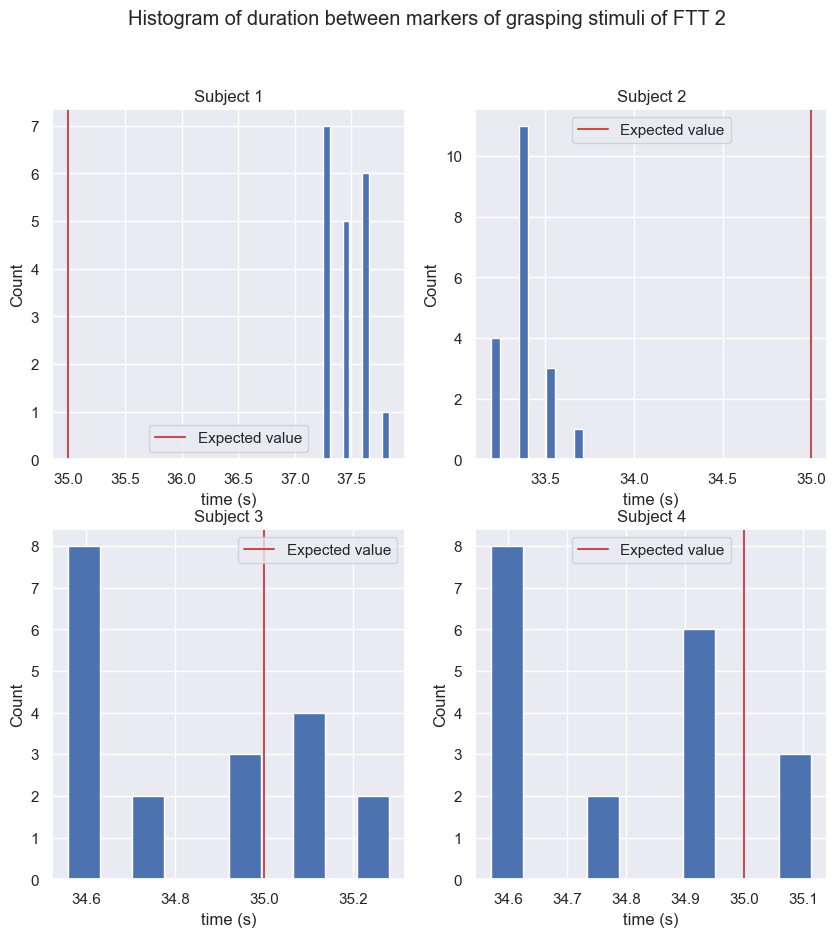

In [11]:
%matplotlib inline
# Determine duration between stimuli: expected to be 12 s + 23 s = 35 s
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (10,10))
fig.suptitle('Histogram of duration between markers of grasping stimuli of FTT 2')
for sub, ax in enumerate([ax1,ax2,ax3,ax4]):
    # Get IDs of test events
    ids = [event_dicts[sub]['test/LEFT'], event_dicts[sub]['test/RIGHT']]
    inter_stim = np.diff(events[sub][np.isin(events[sub][:,2], ids)][:,0])/raw_intensities[sub].info['sfreq']
    # plot
    ax.hist(inter_stim)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Count')
    ax.set_title('Subject ' + str(sub+1))
    ax.axvline(35, color = 'r', label = 'Expected value')
    ax.legend()

if export:
    fig.savefig('Timing_problem_FTT2.png')
    

---
> *Remark:*
- 26 channels * 2 wavelengths = 52 channels
- Different sample frequencies are used for each participant = [5.181347150259067, 5.813953488372094, 5.555555555555555, 5.524861878453039] Hz
- LPF = [2.5906735751295336, 2.906976744186047, 2.7777777777777777, 2.7624309392265194] Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
- 10 random selected control segments within the baseline recording period
- 10 left and 10 right hand grasping segments
---

##### Resample data

In [12]:
f_min = np.min(sfreqs)
for sub in range(4):
    raw_intensities[sub].resample(f_min)

Sampling frequency of the instance is already 5.181347150259067, returning unmodified.


---
> *Remark:*
- Sample frequencies are downsampled to lowest sample frequency of the 4 subjects
- Sample frequency: 5.18 Hz
- LPF = 2.59 Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
---

### Visual inspection <a class="anchor" id="section_1_3"></a>

##### Validate that the location of sources-detector pairs and channels are in the expected locations

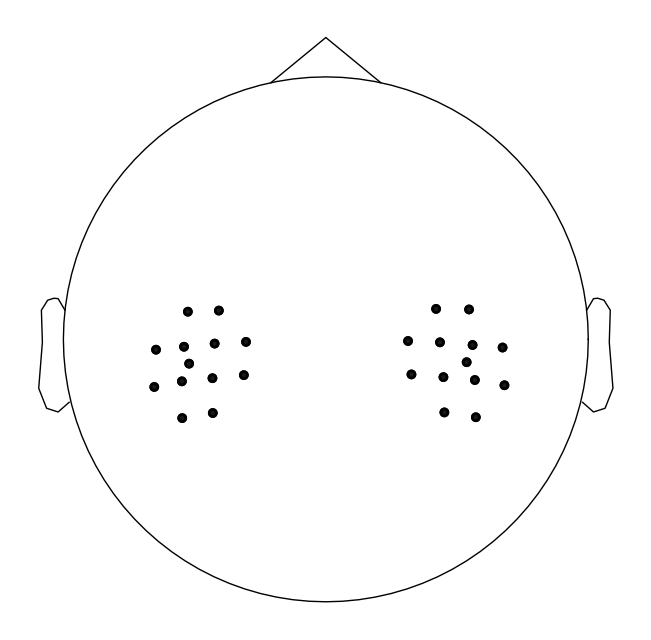

In [13]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensities[0].plot_sensors();

In [14]:
sns.set_theme()
if plot:
    # Plot channels in 3D
    subjects_dir = mne.datasets.sample.data_path() / "subjects"
    mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

    brain = mne.viz.Brain("fsaverage", subjects_dir=subjects_dir, alpha=0.5, cortex="low_contrast")
    brain.add_head()
    
    identity_trans = mne.transforms.Transform("head", "mri") #transformed coord
    brain.add_sensors(raw_intensities[0].info, trans=identity_trans, fnirs=["channels", "pairs", "sources", "detectors"])

    # Add ROI: BA 1, 2, 3 - Primary somatosensory cortex (postcentral gyrus)
            # BA 4 - Primary motor cortex (precentral gyrus)
            # BA 5 - Somatosensory association cortex (NOT PRESENT IN LABELS)
            # BA 6	Premotor and supplementary motor cortex
    brain.add_label("BA1", hemi = "lh", borders=False, color='red')
    brain.add_label("BA1", hemi = "rh", borders=False, color='red')
    brain.add_label("BA2", hemi = "rh", borders=False, color='orange')
    brain.add_label("BA2", hemi = "lh", borders=False, color='orange')
    brain.add_label("BA3a", hemi = "rh", borders=False, color='yellow')
    brain.add_label("BA3b", hemi = "rh", borders=False, color='yellow')
    brain.add_label("BA3a", hemi = "lh", borders=False, color='yellow')
    brain.add_label("BA3b", hemi = "lh", borders=False, color='yellow')
    brain.add_label("BA4a", hemi = "lh", borders=False, color='green')
    brain.add_label("BA4a", hemi = "rh", borders=False, color='green')
    brain.add_label("BA4p", hemi = "lh", borders=False, color='green')
    brain.add_label("BA4p", hemi = "rh", borders=False, color='green')
    brain.add_label("BA6", hemi = "lh", borders=False, color='blue')
    brain.add_label("BA6", hemi = "rh", borders=False, color='blue')
    brain.show_view(azimuth=90, elevation=90, distance=500)

---
> *Remark:*
- 24 long channels and 2 short channels
- 8 sources, 10 detectors and 2 short channel sources
- montage located above sensorimotor cortex
---

##### Visual inspection of the raw light intensity data

###### Subject 1

In [15]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[0].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- Physiological components: Oscillations due to heart rate, Mayer waves
- Extrinsic components: Few spikes due to motion
---

###### Subject 2

In [16]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[1].plot(duration=300, show_scrollbars = True, clipping = None);

This recording exhibits significant noise artifacts, including physiological noise (heartbeat and Mayer waves), numerous small spikes, and some baseline shifts. Focusing on channels S3-D1, S4-D4, and S5-D1 between 480 and 530 seconds, a baseline shift can be identified during the test/LEFT trial, likely due to the subject's head movement during the grasping task. The small spikes, however, appear to be related to the heart rate physiological noise rather than motion artifacts.

Using matplotlib as 2D backend.


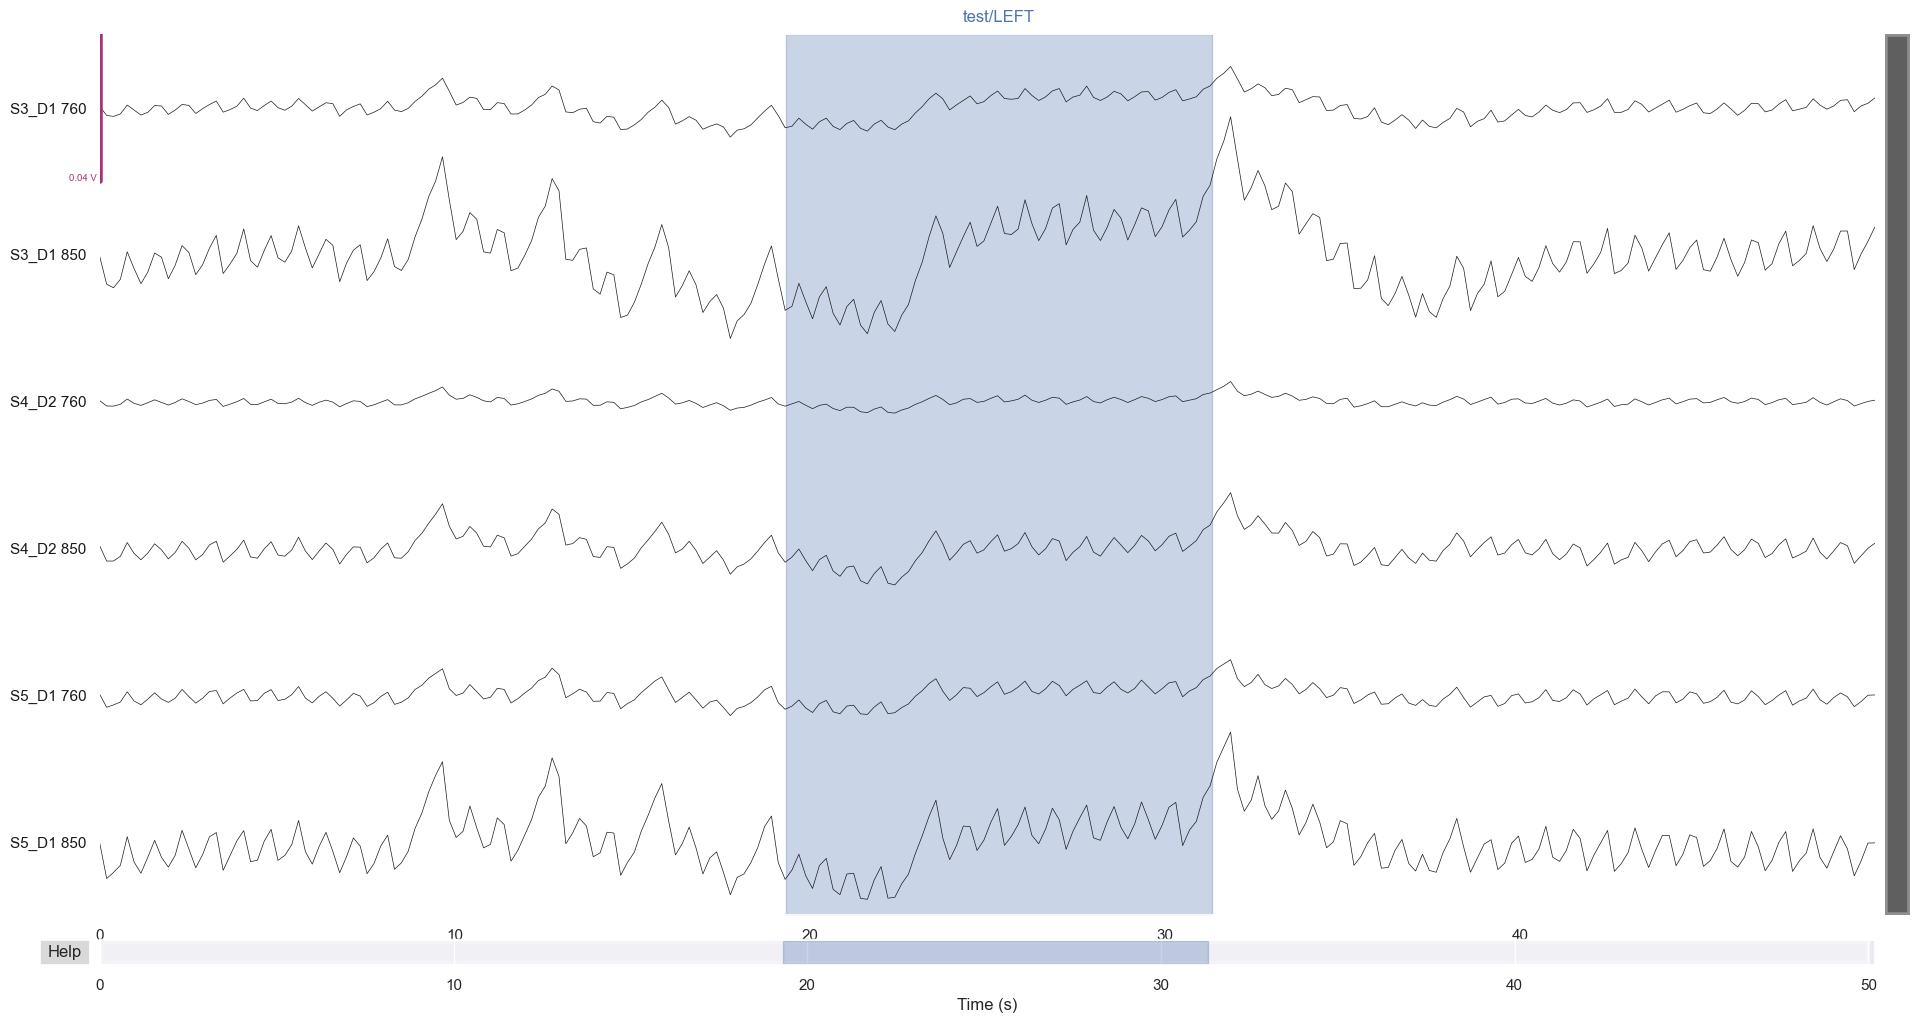

In [17]:
%matplotlib inline
fig = raw_intensities[1].copy().pick(np.arange(4,10)).crop(480,530).plot(duration=50)
if export:
    fig.savefig('FTT2_VI_1.png')

---
> *Remark:*
- Physiological components: Oscillations due to heart rate, less significant Mayer waves
- Extrinsic components: Few spikes due to motion, some baseline drifts
---

###### Subject 3

In [18]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[2].plot(duration=300, show_scrollbars = True, clipping = None);

This recording exhibits some noise artifacts, including physiological noise (heartbeat and Mayer waves), a few spikes, and baseline drifts. Examining channels S1-D1 and S2-D2 between 1015 and 1105 seconds, a baseline drift can be identified.

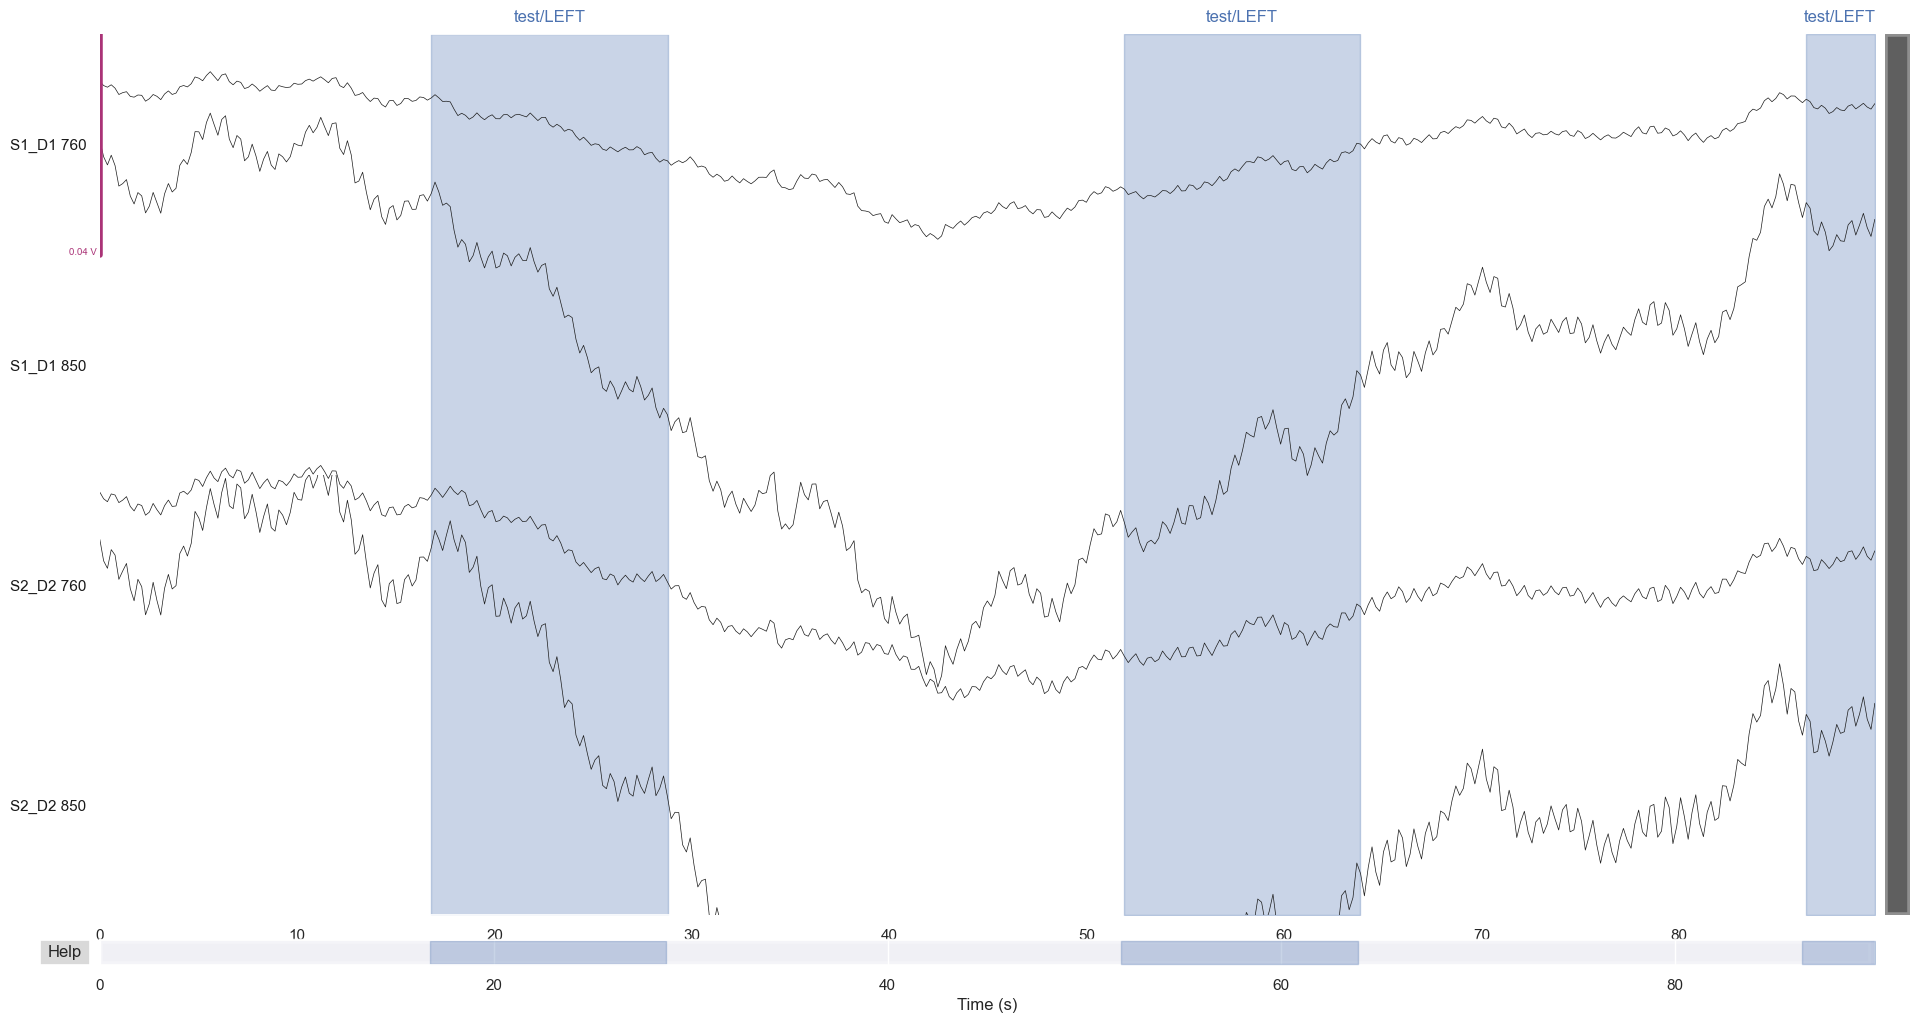

In [19]:
%matplotlib inline
fig = raw_intensities[2].copy().pick(np.arange(0,4)).crop(1015,1105).plot(duration=90)
if export:
    fig.savefig('FTT2_VI_2.png')

---
> *Remark:*
- Physiological components: Oscillations due to heart rate, Mayer waves
- Extrinsic components: Few spikes due to motion, baseline drifts
---

###### Subject 4

In [20]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[3].plot(duration=300, show_scrollbars = True, clipping = None);

In the fourth recording, there is a very noisy signal towards the end, possibly indicating that the participant began moving and removing the cap before the recording was stopped. Zoom in on channels S6-D4 and S7-D3 for the last 95 seconds of the recording. You can clearly see the periodic signals transition into noisy signals.

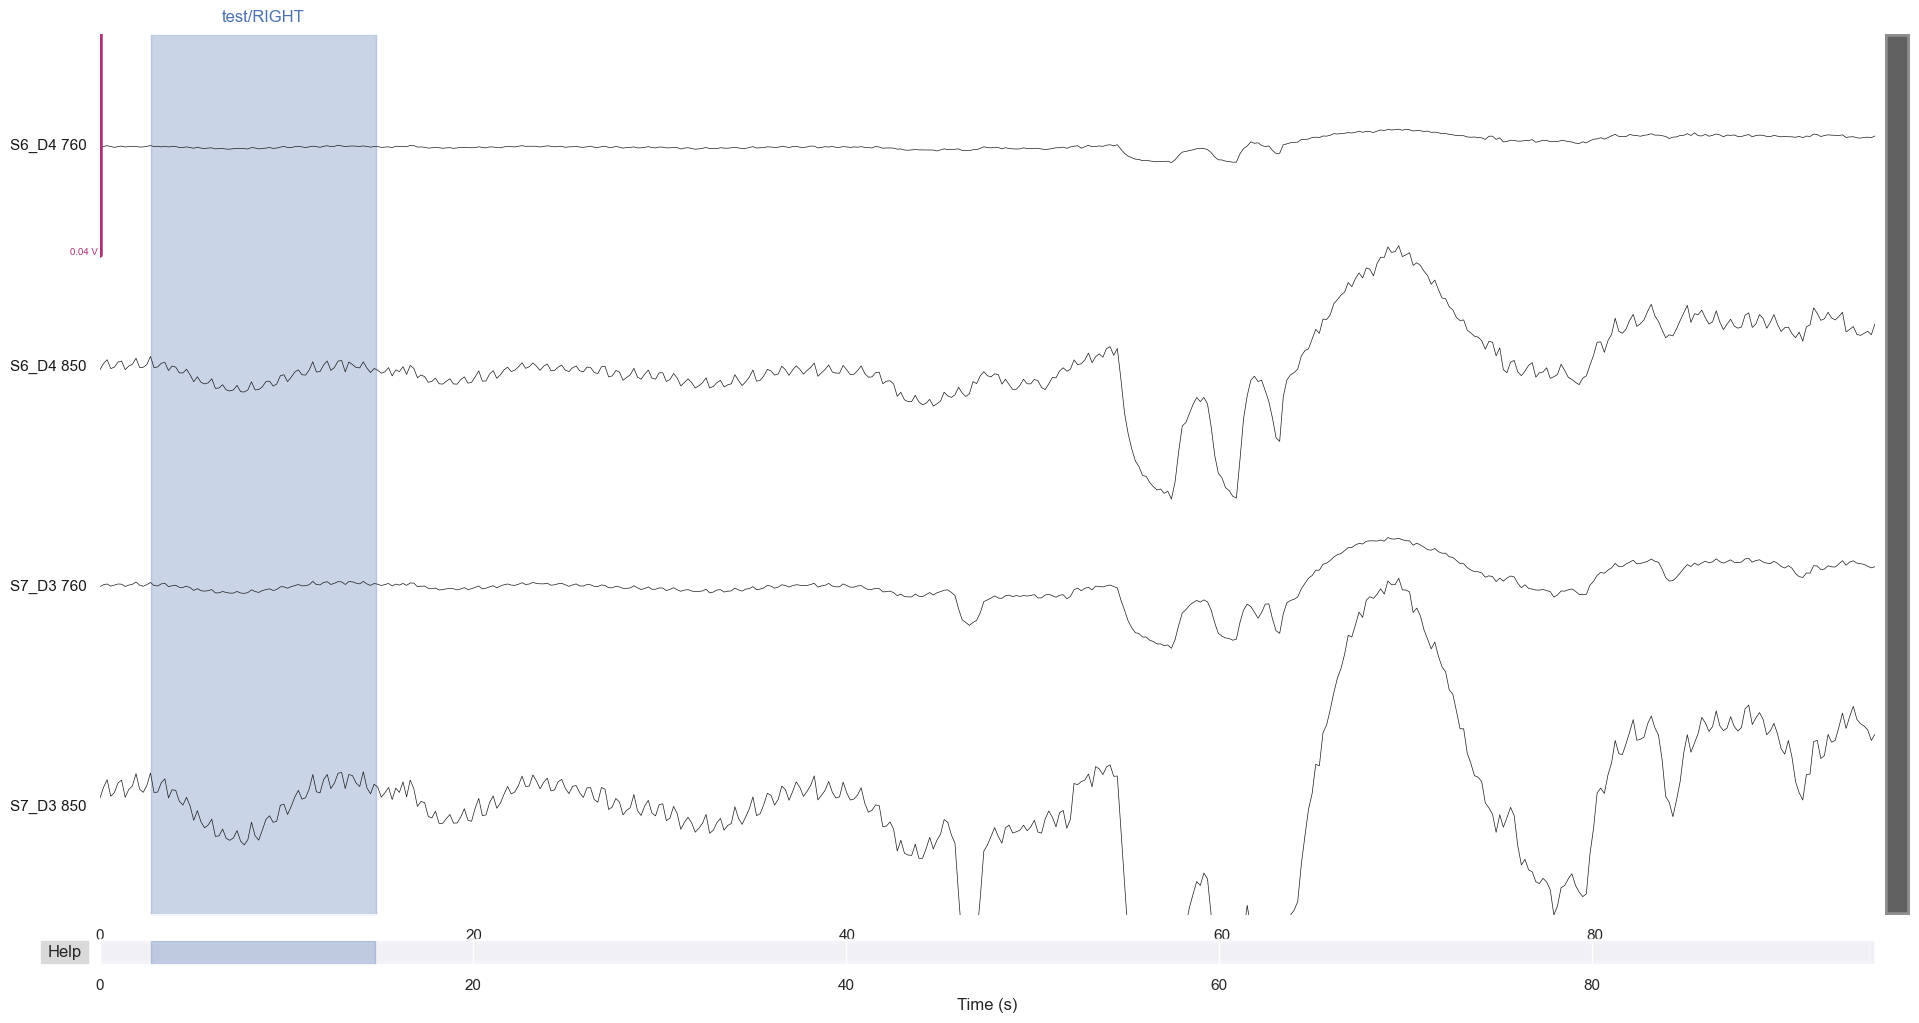

In [21]:
%matplotlib inline
fig = raw_intensities[3].copy().pick(np.arange(18,22)).crop(1030,1125).plot(duration=95)
if export:
    fig.savefig('FTT2_VI_3.png')

A final remark that can be made is related to the adapted task frequency of the experiment. In experiment 1, the participants were asked to perform grasping movements for 10 seconds, followed by an interstimulus period of 20 seconds, leading to a task frequency of $f_{experiment} = \frac{1}{10 s+20s} = 0.033 Hz$. This lead to inflated statistics due to overlap of $f_{experiment}$ and the Mayer waves. In this experiment, the task frequency was changed to $f_{experiment} = \frac{1}{12 s + 23s} = 0.0286 Hz$. As a result, the Mayer waves and task frequency do not consistently overlap anymore. To assess this, zoom in on channels S6-D6 and S9-D1 between 710 and 775 seconds. 

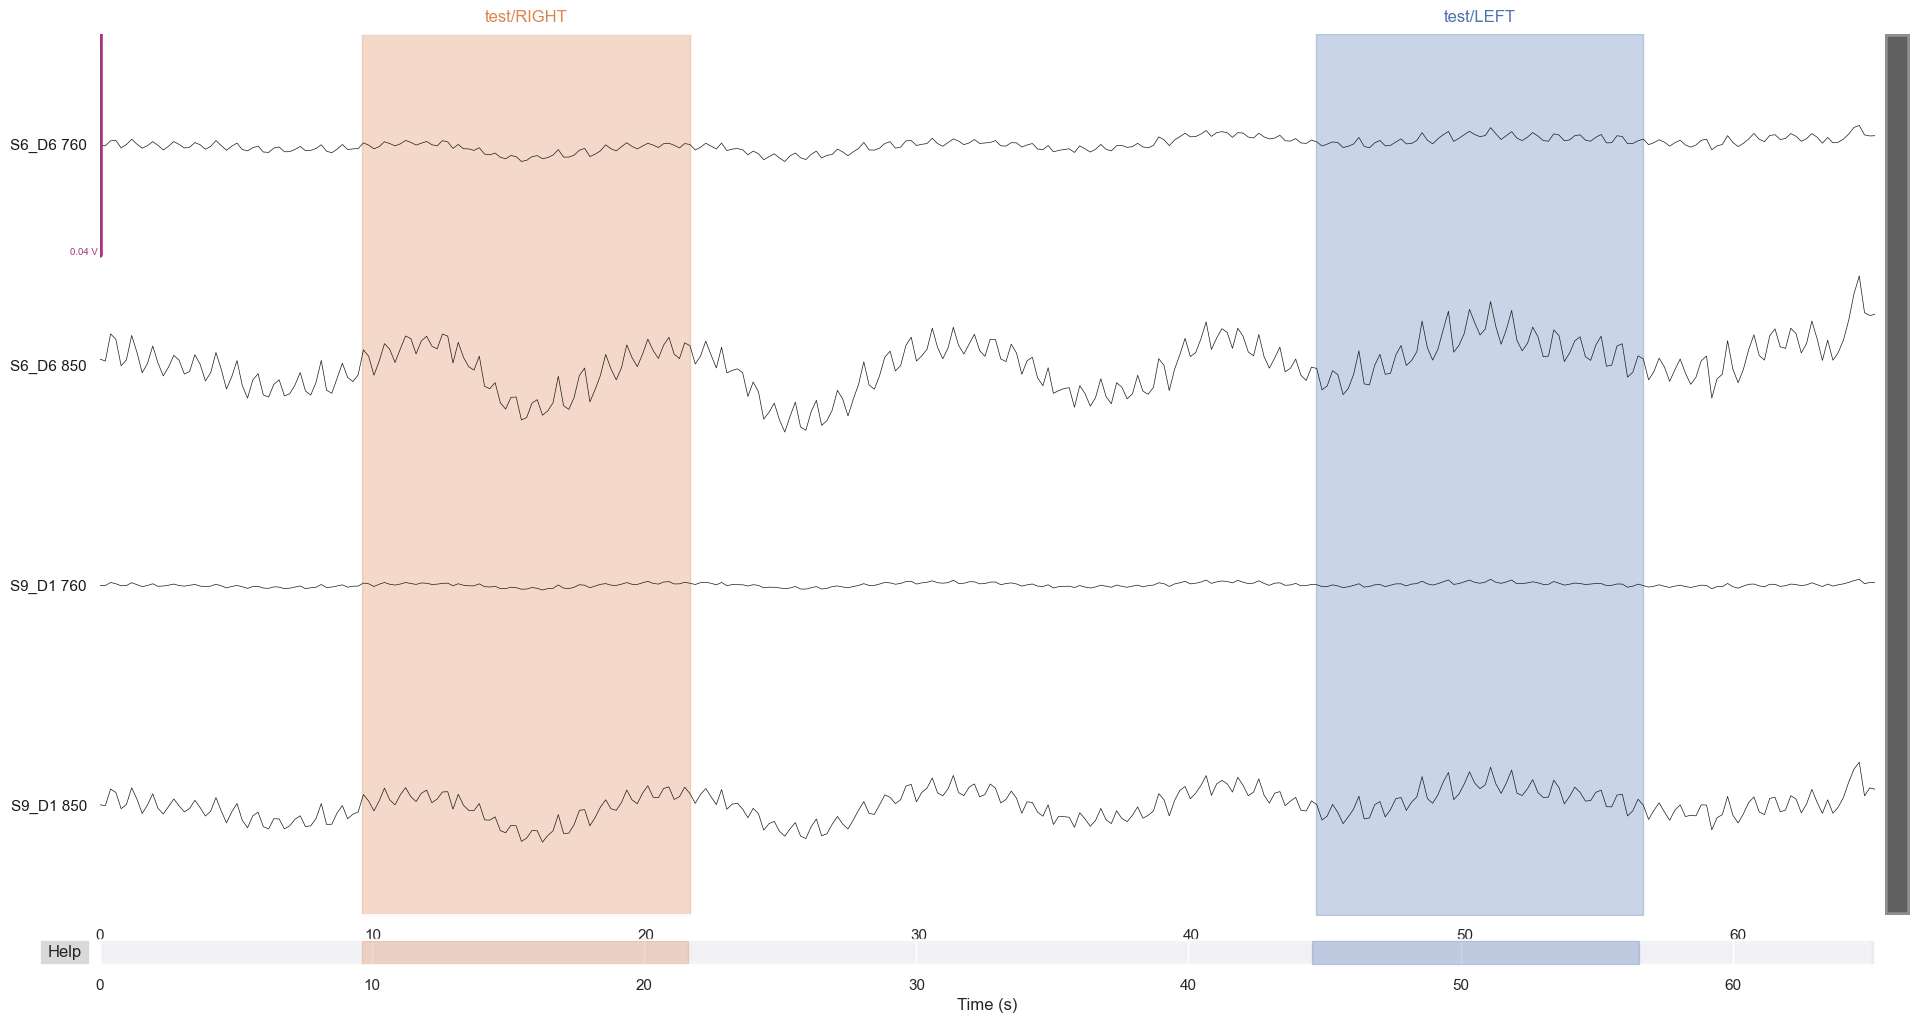

In [22]:
%matplotlib inline
fig = raw_intensities[3].copy().pick(np.arange(30,34)).crop(710,775).plot(duration=65)
if export:
    fig.savefig('FTT2_VI_4.png')

---
> *Remark:*
- Physiological components: Oscillations due to heart rate, Mayer waves
- Extrinsic components: Noisy signal at the end of the recording
---

##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [23]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_ods = []
for sub in range(4):
    raw_ods.append(optical_density(raw_intensities[sub]))

Reading 0 ... 6159  =      0.000 ...  1188.687 secs...


###### Subject 1

In [24]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[0].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- The same observations as in the light intensity data can be made.
---

###### Subject 2

In [25]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[1].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- The same observations as in the light intensity data can be made.
---

###### Subject 3

In [26]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[2].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- The same observations as in the light intensity data can be made.
---

###### Subject 4

In [27]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[3].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- The same observations as in the light intensity data can be made.
---

##### Visual inspection of the haemoglobin concentration

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [28]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
# Separate long and short channels as we will only continue with long channels
raw_haemos = []
raw_haemos_short = []
min_dist = 0.01 
max_dist = 0.045
for sub in range(4):
    raw_haemo = beer_lambert_law(raw_ods[sub], ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.
    raw_haemos_short.append(get_short_channels(raw_haemo, max_dist=max_dist)) 
    raw_haemos.append(get_long_channels(raw_haemo, min_dist=min_dist, max_dist=max_dist))

###### Subject 1

In [29]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_haemos[0].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- No additional observations
---

###### Subject 2

In [30]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_haemos[1].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- No additional observations
---

###### Subject 3

In [31]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_haemos[2].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- No additional observations
---

###### Subject 4

In [32]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_haemos[3].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- No additional observations
---

#### Physiological noise <a class="anchor" id="sub_section_1_3_1"></a>

---
- Mayerwaves and heart beats are clearly visible in most recordings
---

#### Spikes <a class="anchor" id="sub_section_1_3_2"></a>

---
- Spikes are present in all recordings, but often not influencing the task trials.
- Small peaks related to heartrate observed in subject 2.
---

#### Baseline shifts <a class="anchor" id="sub_section_1_3_3"></a>

---
- Some baseline shift were found.
---

#### Baseline drifts <a class="anchor" id="sub_section_1_3_4"></a>

---
- Few baseline drifts were found.
---

### Signal quality metrics and channel rejection <a class="anchor" id="section_1_4"></a>

##### Separate long and short channels

In [33]:
raw_ods_full = []
raw_ods_short = []
raw_ods_new = []
for sub in range(4):
    raw_ods_full.append(raw_ods[sub].copy())
    raw_ods_short.append(get_short_channels(raw_ods[sub], max_dist=max_dist))
    raw_ods_new.append(get_long_channels(raw_ods[sub], min_dist=min_dist, max_dist=max_dist))

In [34]:
raw_ods = raw_ods_new

#### Scalp Coupling Index <a class="anchor" id="sub_section_1_4_2"></a>

The SCI is a quality measurement of the connection between the optodes and the scalp of the participant using the strong cardiac oscillation in raw fNIRS signals. With a sufficiently high sampling rate (e.g.: 10 Hz), the heartbeat emerges as a dependable marker for evaluating optode-scalp coupling. It was first introduced by Pollonini et al. (2013) and it assesses the synchronous cardiac pulsation in the two photodetected signals (760 and 850 nm) in the cardiac band (0.5 - 2.5 Hz). After the bandpass-filtering the resulting signals are normalized to balance any difference between their amplitude. Finally, the zero-lag cross-correlation between photodetected signals of the same channel is used as a quantitative measure of the SNR of that specific channel. A threshold of SCI $>$ 0.75 is recommended by the authors.

Given that the frequency band of 0.5 - 2.5 Hz is quite broad and the participants are relatively at rest while seated, a FIR filter with a narrower band of 0.7 - 1.5 Hz is applied (40 bpm - 85 bpm). The transition band width at both the low and high cut-off frequencies is set to 0.3 Hz.

##### SCI evaluated over complete signal

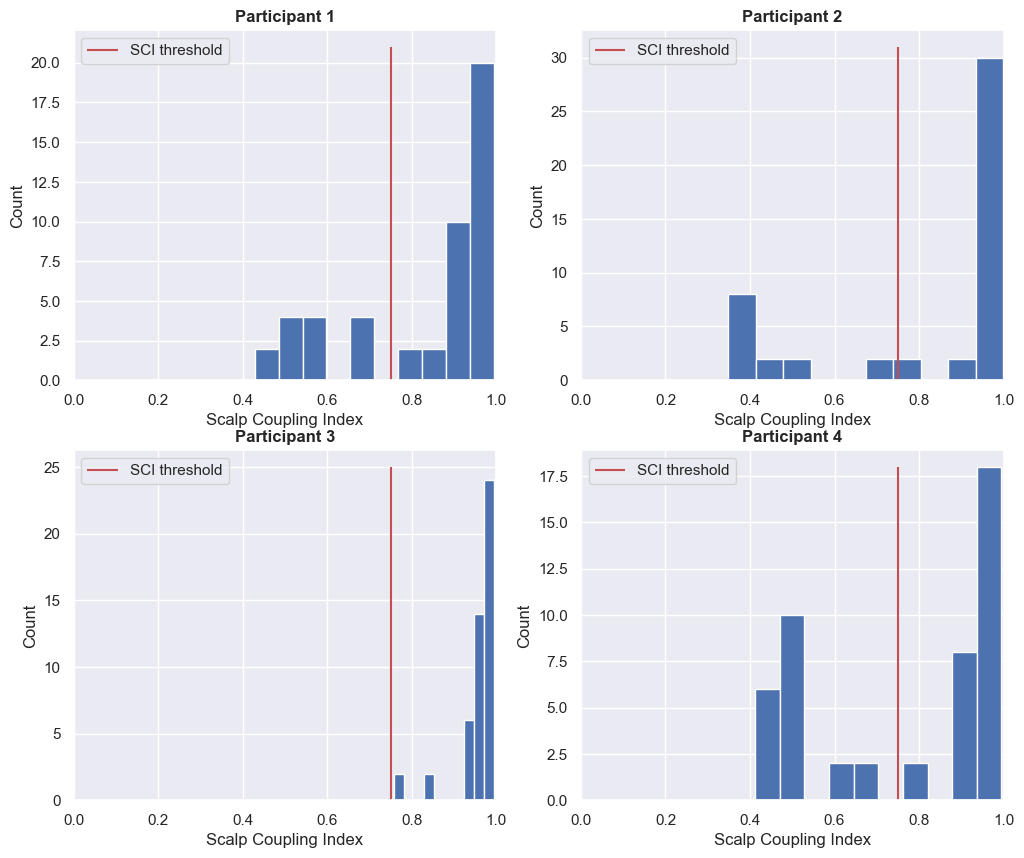

In [35]:
# Calculate SCI with build-in function of mne_nirs
scis = []
for sub in range(4):
    scis.append(scalp_coupling_index(raw_ods[sub], l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3, verbose=False))
    # SCI bandpasses the signal with a FIR filter: l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3

# Plot histogram of SCI values
%matplotlib inline
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,10))

ax1.hist(scis[0])
ax1.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
ax1.vlines(0.75, ymin = 0, ymax = 21, color = 'r', label = 'SCI threshold')
ax1.legend()
ax1.set_title('Participant 1', fontweight="bold")

ax2.hist(scis[1])
ax2.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
ax2.vlines(0.75, ymin = 0, ymax = 31, color = 'r', label = 'SCI threshold')
ax2.legend()
ax2.set_title('Participant 2', fontweight="bold")

ax3.hist(scis[2])
ax3.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
ax3.vlines(0.75, ymin = 0, ymax = 25, color = 'r', label = 'SCI threshold')
ax3.legend()
ax3.set_title('Participant 3', fontweight="bold")

ax4.hist(scis[3])
ax4.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
ax4.vlines(0.75, ymin = 0, ymax = 18, color = 'r', label = 'SCI threshold')
ax4.legend()
ax4.set_title('Participant 4', fontweight="bold")

if export:
    plt.savefig('FTT2_SCI.png')
plt.show()

In [36]:
# Copy raw object to apply SCI 
raw_od_SCIs = []
for sub in range(4):
    raw_od_SCIs.append(raw_ods[sub].copy())
# Mark channels with SCI < 0.75 as BAD
for sub in range(4):
    raw_od_SCIs[sub].info['bads'] = list(compress(raw_ods[sub].ch_names, scis[sub] < 0.75)) # 0.75 RECOMMENDED BY Pollonini et al. (2013)
    print('The ' + str(len(raw_od_SCIs[sub].info['bads'])) + ' bad channels for subject ' + str(sub+1) + ' are: ' + str(raw_od_SCIs[sub].info['bads']))

The 14 bad channels for subject 1 are: ['S3_D1 760', 'S3_D1 850', 'S7_D1 760', 'S7_D1 850', 'S6_D4 760', 'S6_D4 850', 'S7_D3 760', 'S7_D3 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S7_D9 760', 'S7_D9 850']
The 16 bad channels for subject 2 are: ['S2_D2 760', 'S2_D2 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']
The 0 bad channels for subject 3 are: []
The 20 bad channels for subject 4 are: ['S1_D1 760', 'S1_D1 850', 'S3_D1 760', 'S3_D1 850', 'S5_D1 760', 'S5_D1 850', 'S7_D1 760', 'S7_D1 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']


###### Subject 1

In [37]:
# Inspect bad channels (grey color)
if plot:
    %matplotlib qt
    raw_od_SCIs[0].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 2

In [38]:
# Inspect bad channels (grey color)
if plot:
    %matplotlib qt
    raw_od_SCIs[1].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 3

In [39]:
# Inspect bad channels (grey color)
if plot:
    %matplotlib qt
    raw_od_SCIs[2].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 4

In [40]:
# Inspect bad channels (grey color)
if plot:
    %matplotlib qt
    raw_od_SCIs[3].plot(duration=300, show_scrollbars = True, clipping = None);

###### Topomap

In [41]:
# Bad channels are now displayed in red
%matplotlib qt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 21))

raw_od_SCIs[0].plot_sensors(axes=axes[0,0])
raw_od_SCIs[1].plot_sensors(axes=axes[0,1])
raw_od_SCIs[2].plot_sensors(axes=axes[1,0])
raw_od_SCIs[3].plot_sensors(axes=axes[1,1])
axes[0,0].set_title('Participant 1', fontweight="bold")
axes[0,1].set_title('Participant 2', fontweight="bold")
axes[1,0].set_title('Participant 3', fontweight="bold")
axes[1,1].set_title('Participant 4', fontweight="bold")

if export:
    fig.savefig('FTT2_SCI_bad_channels.png')

fig.show()

In [42]:
# Look at characteristics
for sub in range(4):
    print(raw_od_SCIs[sub].info)

<Info | 13 non-empty values
 bads: 14 items (S3_D1 760, S3_D1 850, S7_D1 760, S7_D1 850, S6_D4 760, ...)
 ch_names: S1_D1 760, S1_D1 850, S2_D2 760, S2_D2 850, S3_D1 760, S3_D1 ...
 chs: 48 fNIRS (OD)
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 20 items (20 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 2.6 Hz
 meas_date: 2024-03-15 14:38:45 UTC
 nchan: 48
 projs: []
 sfreq: 5.2 Hz
 subject_info: 5 items (dict)
>
<Info | 13 non-empty values
 bads: 16 items (S2_D2 760, S2_D2 850, S8_D2 760, S8_D2 850, S8_D4 760, ...)
 ch_names: S1_D1 760, S1_D1 850, S2_D2 760, S2_D2 850, S3_D1 760, S3_D1 ...
 chs: 48 fNIRS (OD)
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 20 items (20 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 2.6 Hz
 meas_date: 2024-03-21 11:17:13 UTC
 nchan: 48
 projs: []
 sfreq: 5.2 Hz
 subje

---
> *Remark:*
- Expect for participant 3, a large number of the channels are marked as bad by SCI
- Lowering the threshold permits more signals to be included in the analysis. However, if the signal quality is poor, the reliability of the statistical results decreases.
---

##### SCI evaluated over moving window

###### Subject 1

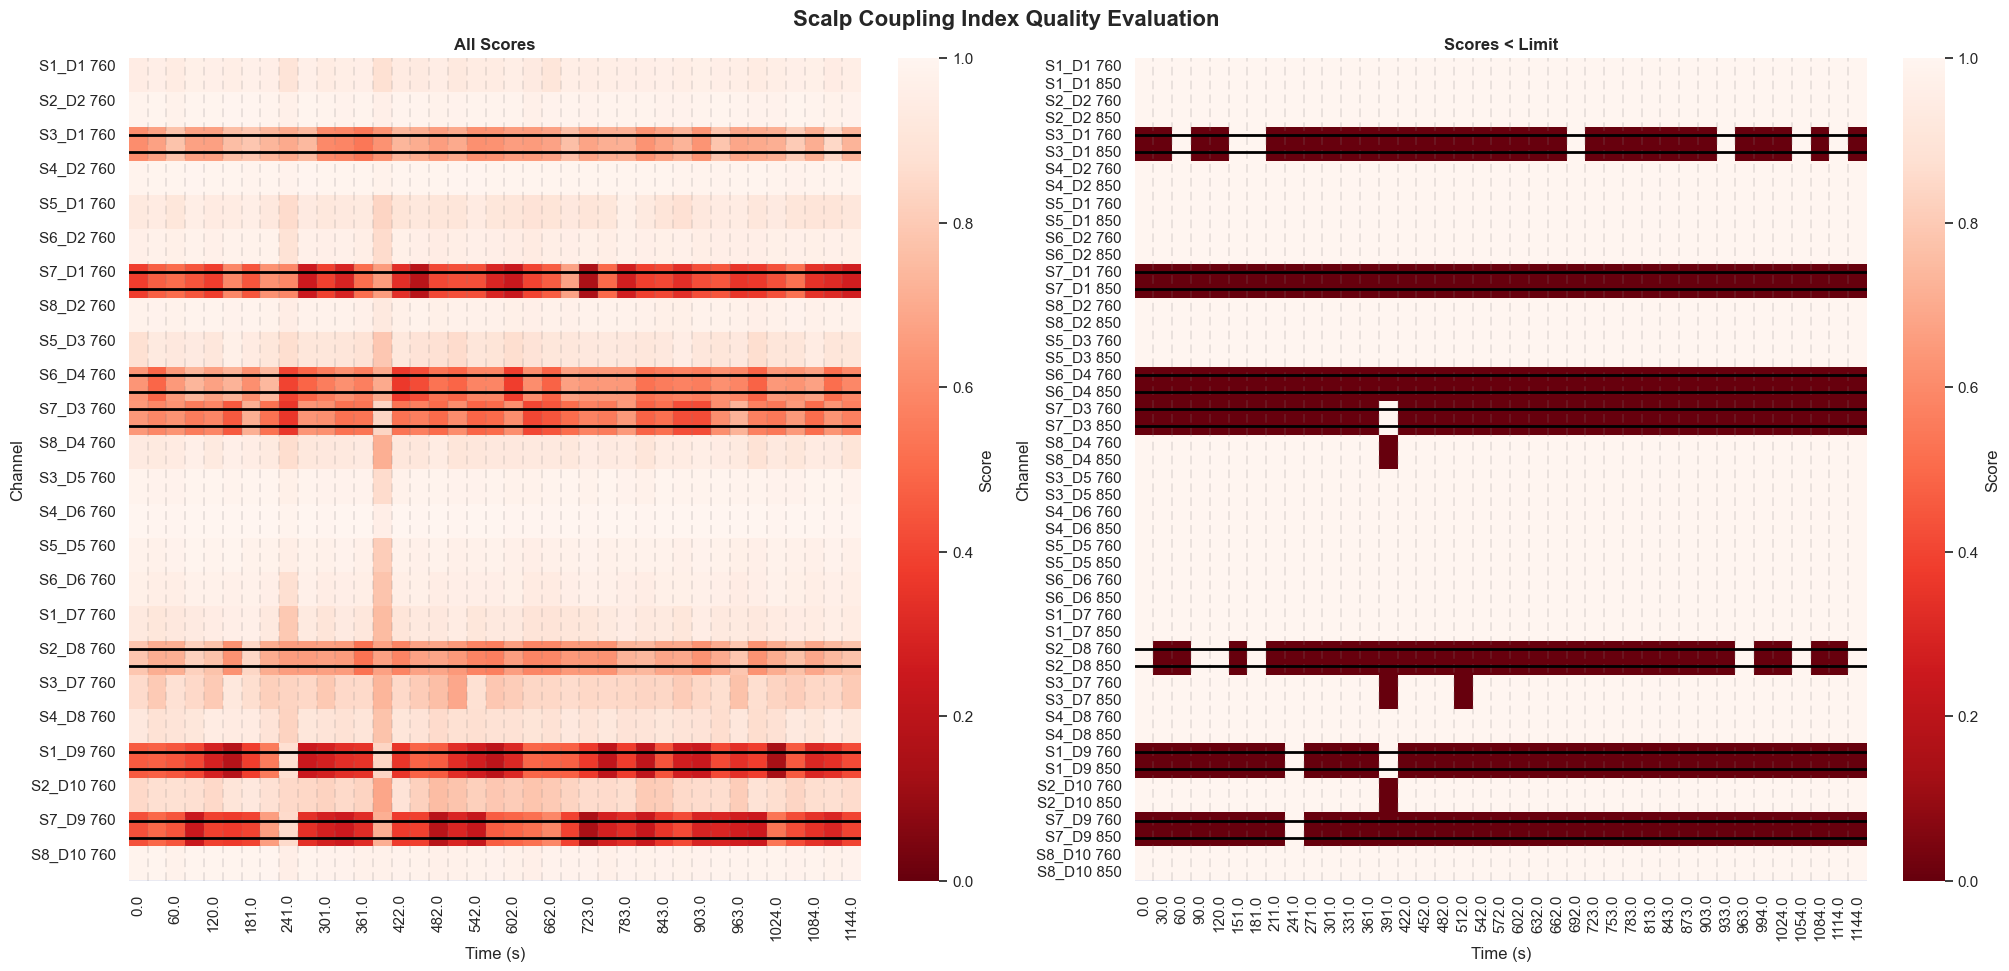

In [43]:
# Calculate windowed SCI with windows of 30 s
_, scores, times = scalp_coupling_index_windowed(raw_od_SCIs[0], time_window=30)

%matplotlib inline
# Plot
plot_timechannel_quality_metric(raw_od_SCIs[0], scores, times, threshold=0.75, title="Scalp Coupling Index Quality Evaluation");

---
> *Remark:*
- 14 channels will be rejected for the full recording based on the SCI
- No significant other segments indicated
---

###### Subject 2

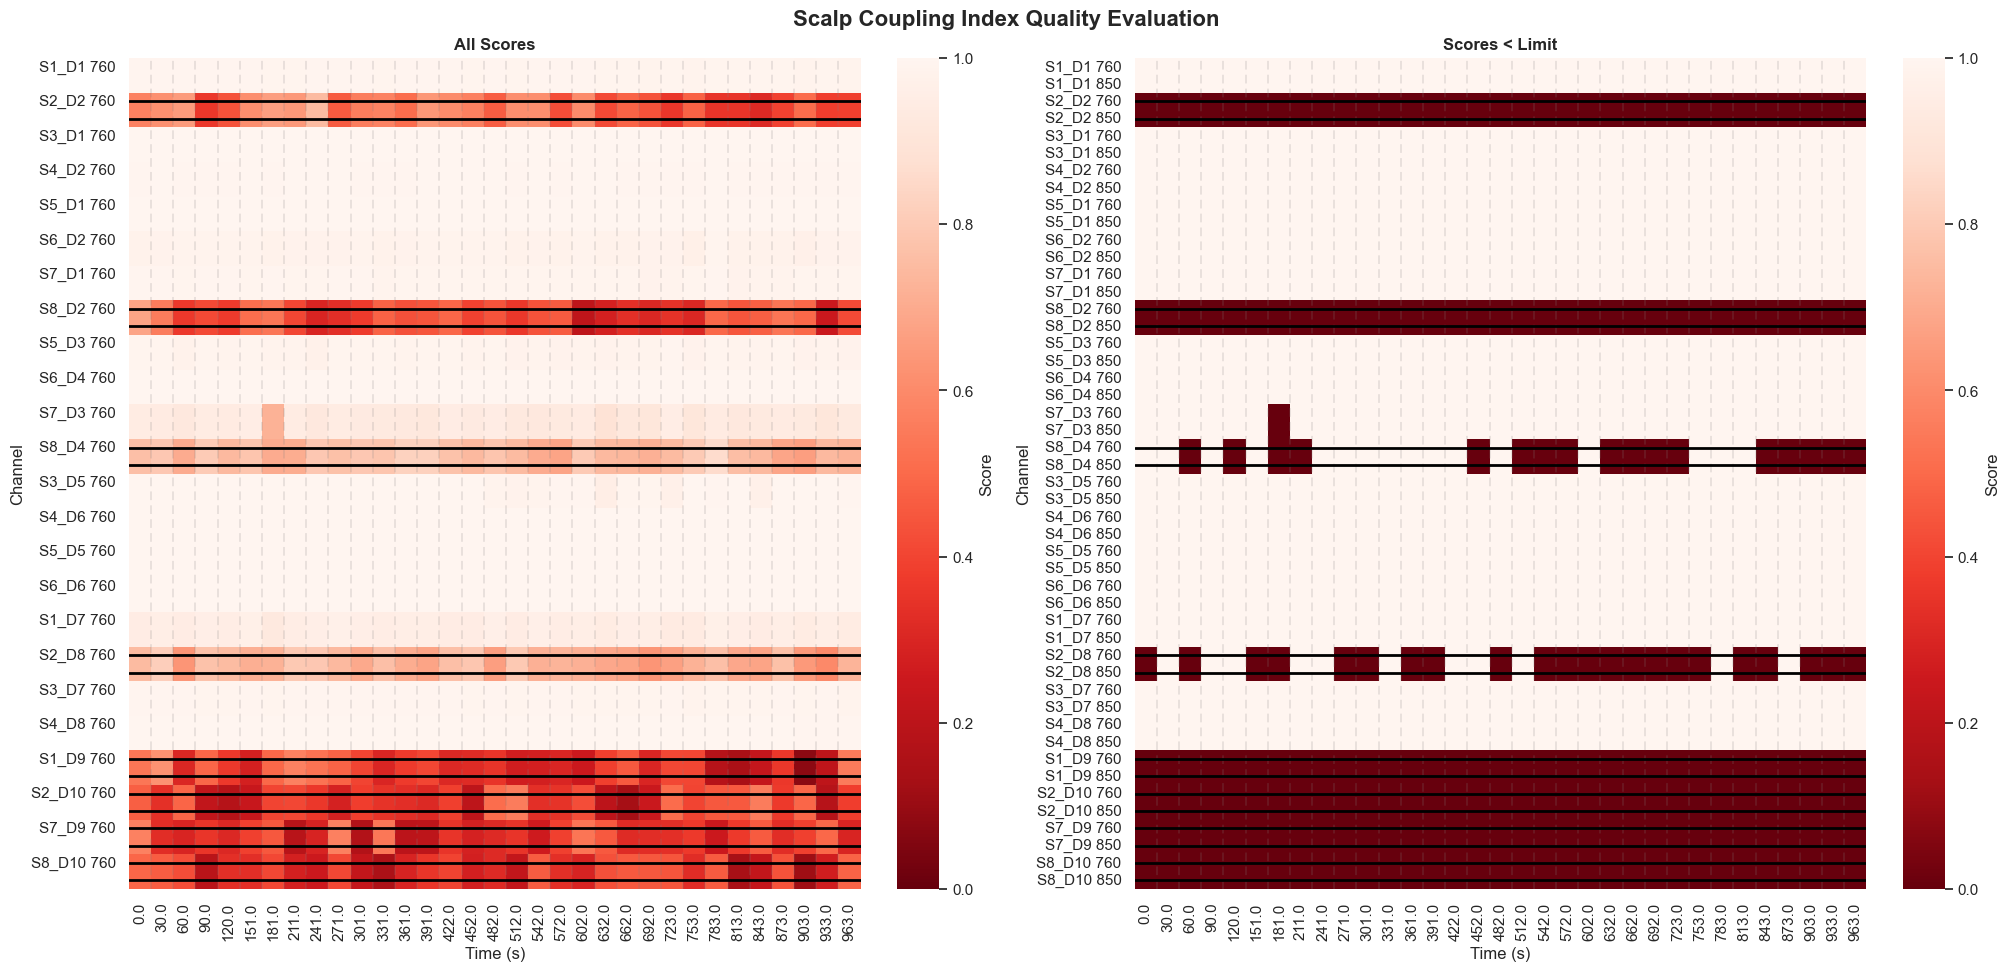

In [44]:
# Calculate windowed SCI with windows of 30 s
_, scores, times = scalp_coupling_index_windowed(raw_od_SCIs[1], time_window=30)

%matplotlib inline
# Plot
plot_timechannel_quality_metric(raw_od_SCIs[1], scores, times, threshold=0.75, title="Scalp Coupling Index Quality Evaluation");

---
> *Remark:*
- 16 channels will be rejected for the full recording based on the SCI
- No significant other segments indicated
---

###### Subject 3

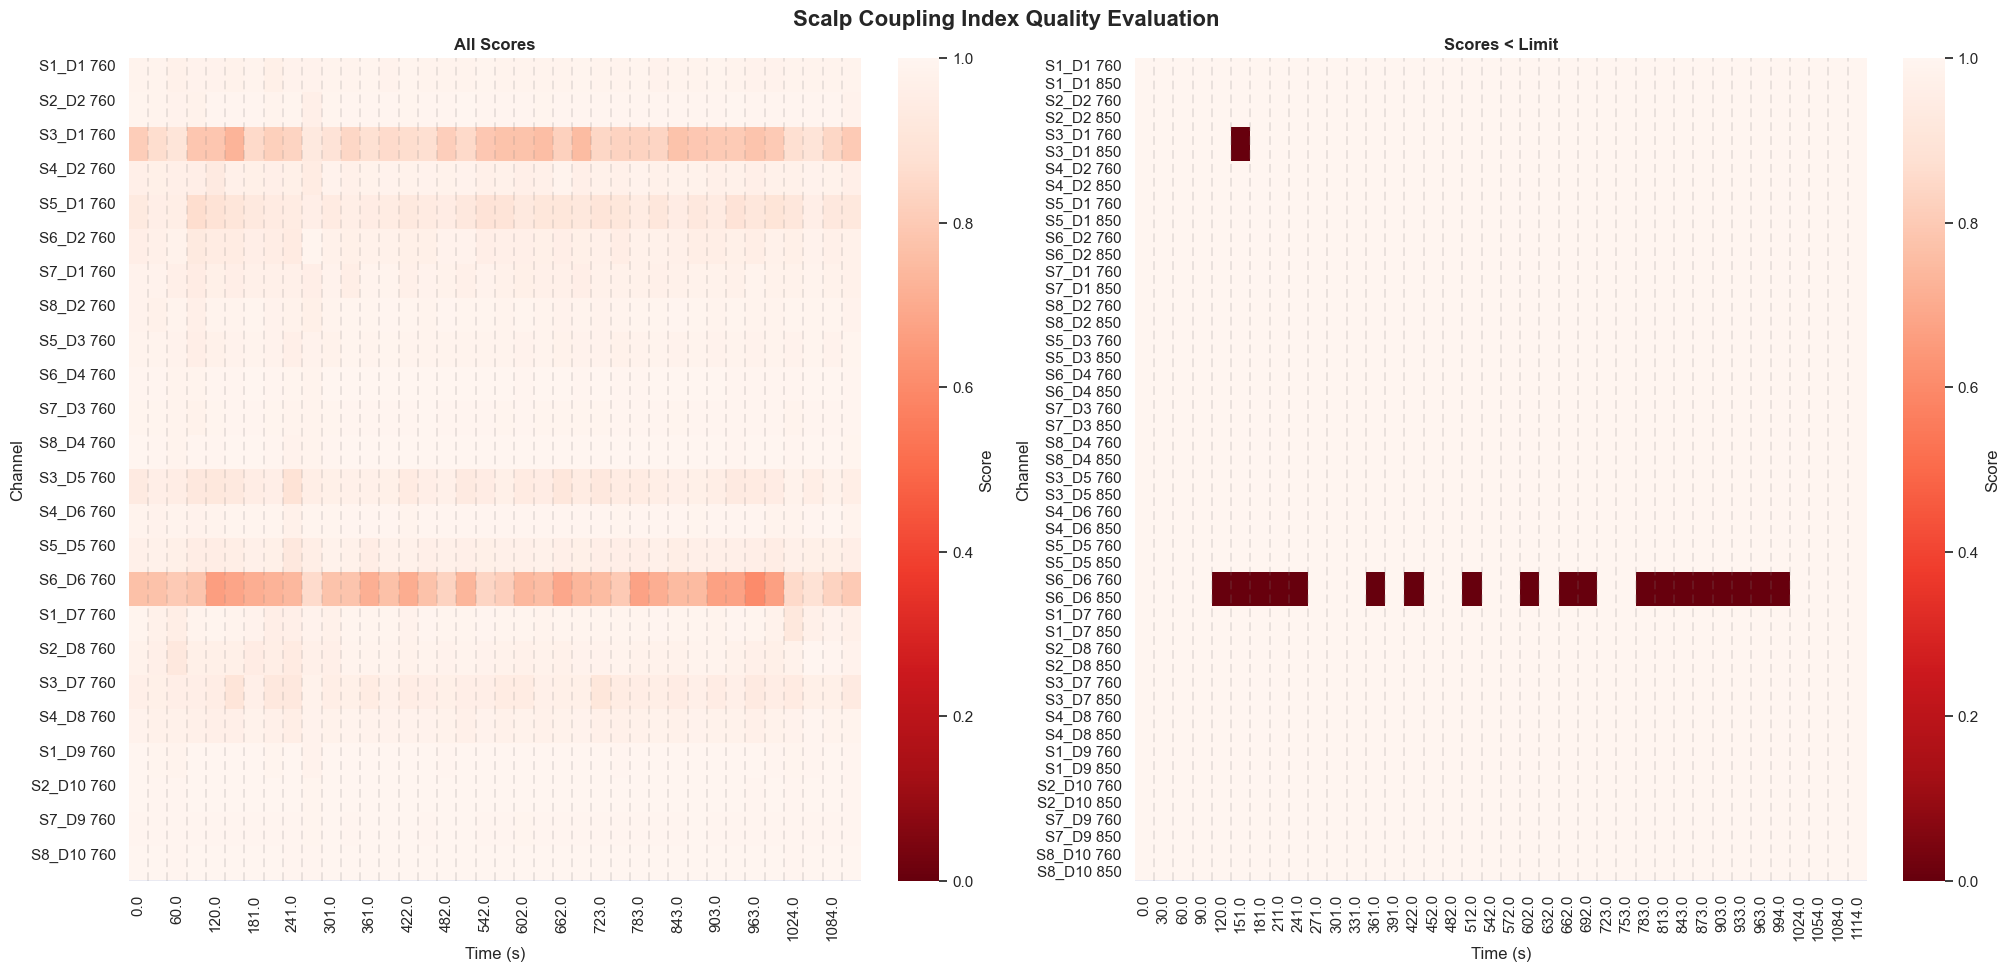

In [45]:
# Calculate windowed SCI with windows of 30 s
_, scores, times = scalp_coupling_index_windowed(raw_od_SCIs[2], time_window=30)

%matplotlib inline
# Plot
plot_timechannel_quality_metric(raw_od_SCIs[2], scores, times, threshold=0.75, title="Scalp Coupling Index Quality Evaluation");

---
> *Remark:*
- 0 channels will be rejected for the full recording based on the SCI
- Channel S6-D6 will be set as bad based on the moving window SCI
---

In [46]:
# Add bad channels
raw_od_SCIs[2].info['bads'] += ['S6_D6 760', 'S6_D6 850']

###### Subject 4

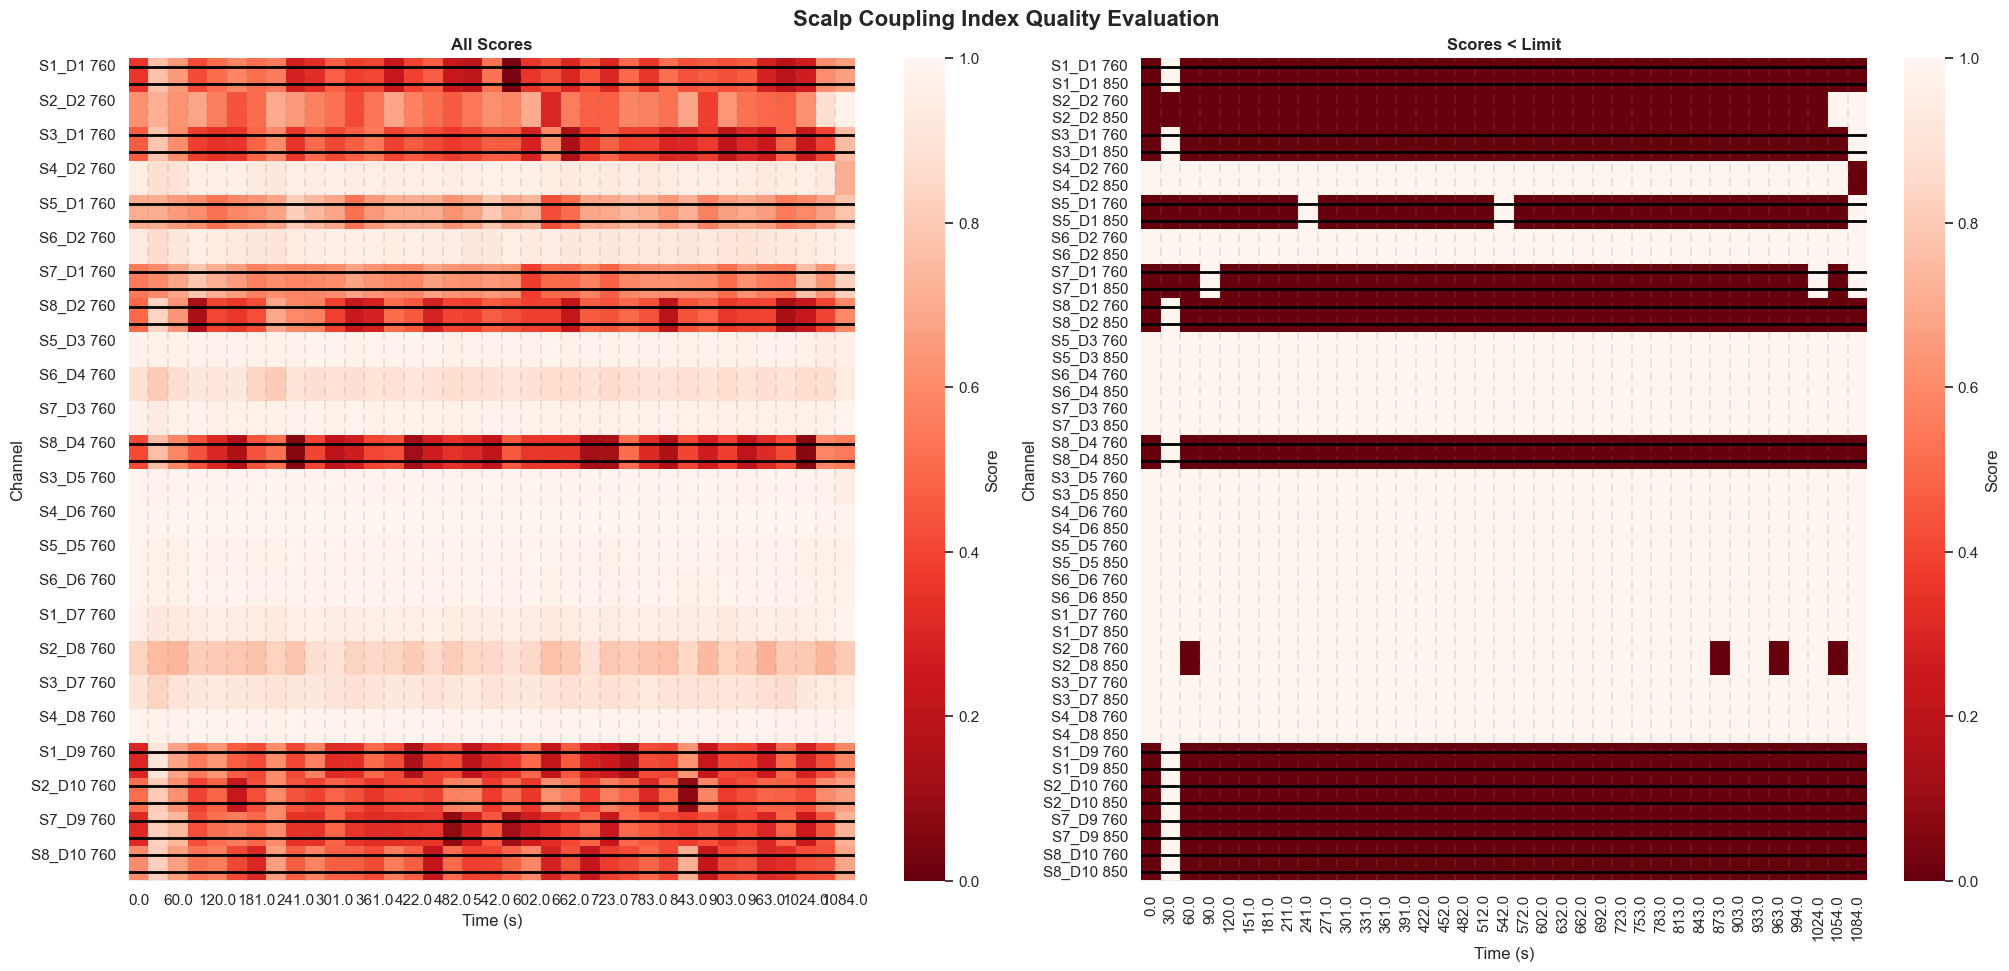

In [47]:
# Calculate windowed SCI with windows of 30 s
_, scores, times = scalp_coupling_index_windowed(raw_od_SCIs[3], time_window=30)

%matplotlib inline
# Plot
plot_timechannel_quality_metric(raw_od_SCIs[3], scores, times, threshold=0.75, title="Scalp Coupling Index Quality Evaluation");

---
> *Remark:*
- 20 channels will be rejected for the full recording based on the SCI
- Channel S2-D2 will be set as bad based on the moving window SCI
---

In [48]:
# Add bad channels
raw_od_SCIs[3].info['bads'] += ['S2_D2 760', 'S2_D2 850']

##### Summary of bad channels

In [49]:
bad_channels = np.zeros((len(raw_od_SCIs[0].ch_names), 4)).astype(int)
df_bad_channels = pd.DataFrame(bad_channels, index = raw_od_SCIs[0].ch_names, columns = ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4'])
for sub, subject in enumerate(['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4']):
    df_bad_channels[subject].loc[raw_od_SCIs[sub].info['bads']] = 1

In [50]:
if export:
    df_bad_channels.to_csv('Bad_channels_FTT2.csv')

In [49]:
df_bad_channels.style.background_gradient(cmap='Blues')

,Subject 1,Subject 2,Subject 3,Subject 4
S1_D1 760,0,0,0,1
S1_D1 850,0,0,0,1
S2_D2 760,0,1,0,1
S2_D2 850,0,1,0,1
S3_D1 760,1,0,0,1
S3_D1 850,1,0,0,1
S4_D2 760,0,0,0,0
S4_D2 850,0,0,0,0
S5_D1 760,0,0,0,1
S5_D1 850,0,0,0,1


In [50]:
if export:
    dfi.export(df_bad_channels.style.background_gradient(cmap='Blues'),"FTT2_SCI_BAD_TABLE.png")

#### Peak Spectral Power <a class="anchor" id="sub_section_1_4_3"></a>

Pollonini et al. (2016) state that to enhance the reliability of a quantitative measure for scalp coupling, the spectral power of the cross-correlated signal can serve as an additional indicator of cardiac signal strength. By setting a spectral power threshold, it becomes possible to objectively differentiate between a clear optical channel and a noisy one. Theoretically, photodetected cardiac signals can be conceptualized as two sinusoidal waves oscillating at the physiological frequency $f_{cardiac}$ (e.g.: 1 Hz or 60 bpm) with arbitrary amplitude and offset. The resultant normalized cross-correlation signal ($\overline{x_{\lambda_1}}  \otimes \overline{x_{\lambda_2}}$) exhibits unity amplitude, a frequency of $f_{cardiac}$ and a peak power of 0.5. Therefore, a threshold can be established at a certain fraction of the ideal peak power. However, in practice, cardiac photoplethysmographic signals are not strictly sinusoidal and may contain quantization noise, which reduces the peak power value. Hence, the authors recommend empirically setting the threshold value at 0.1.

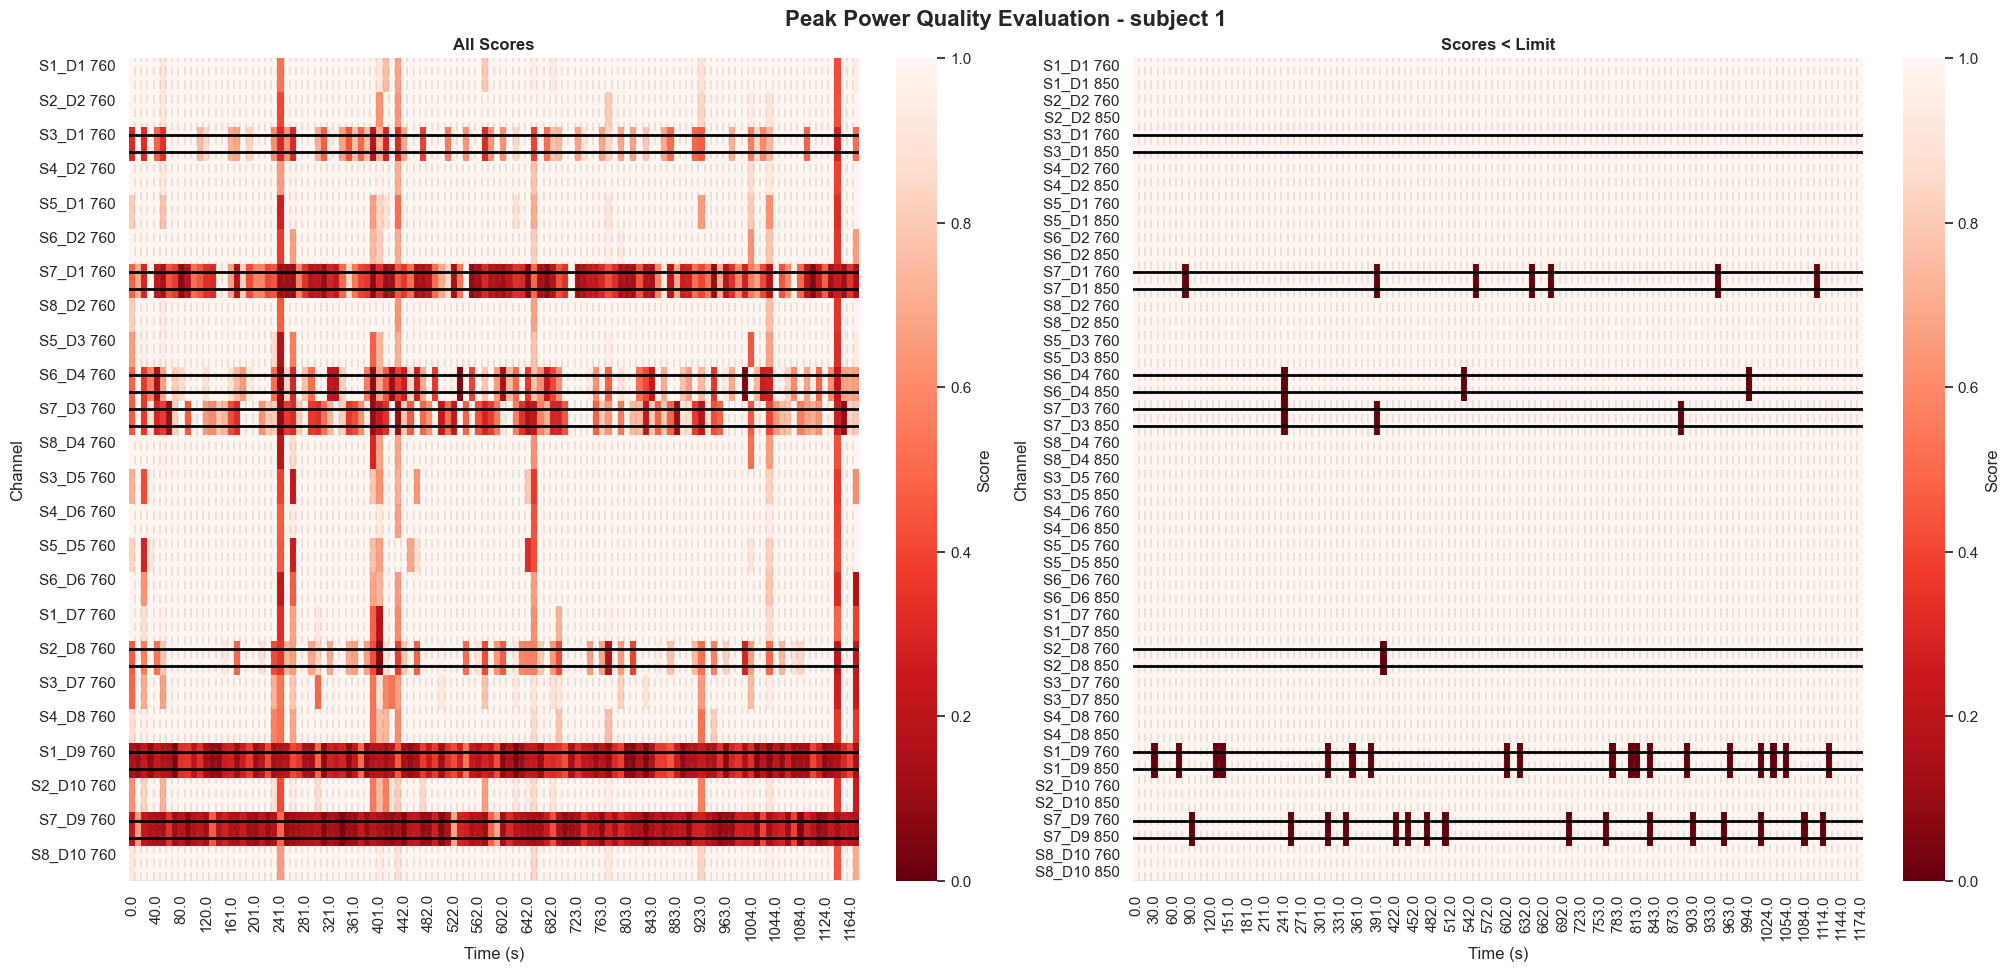

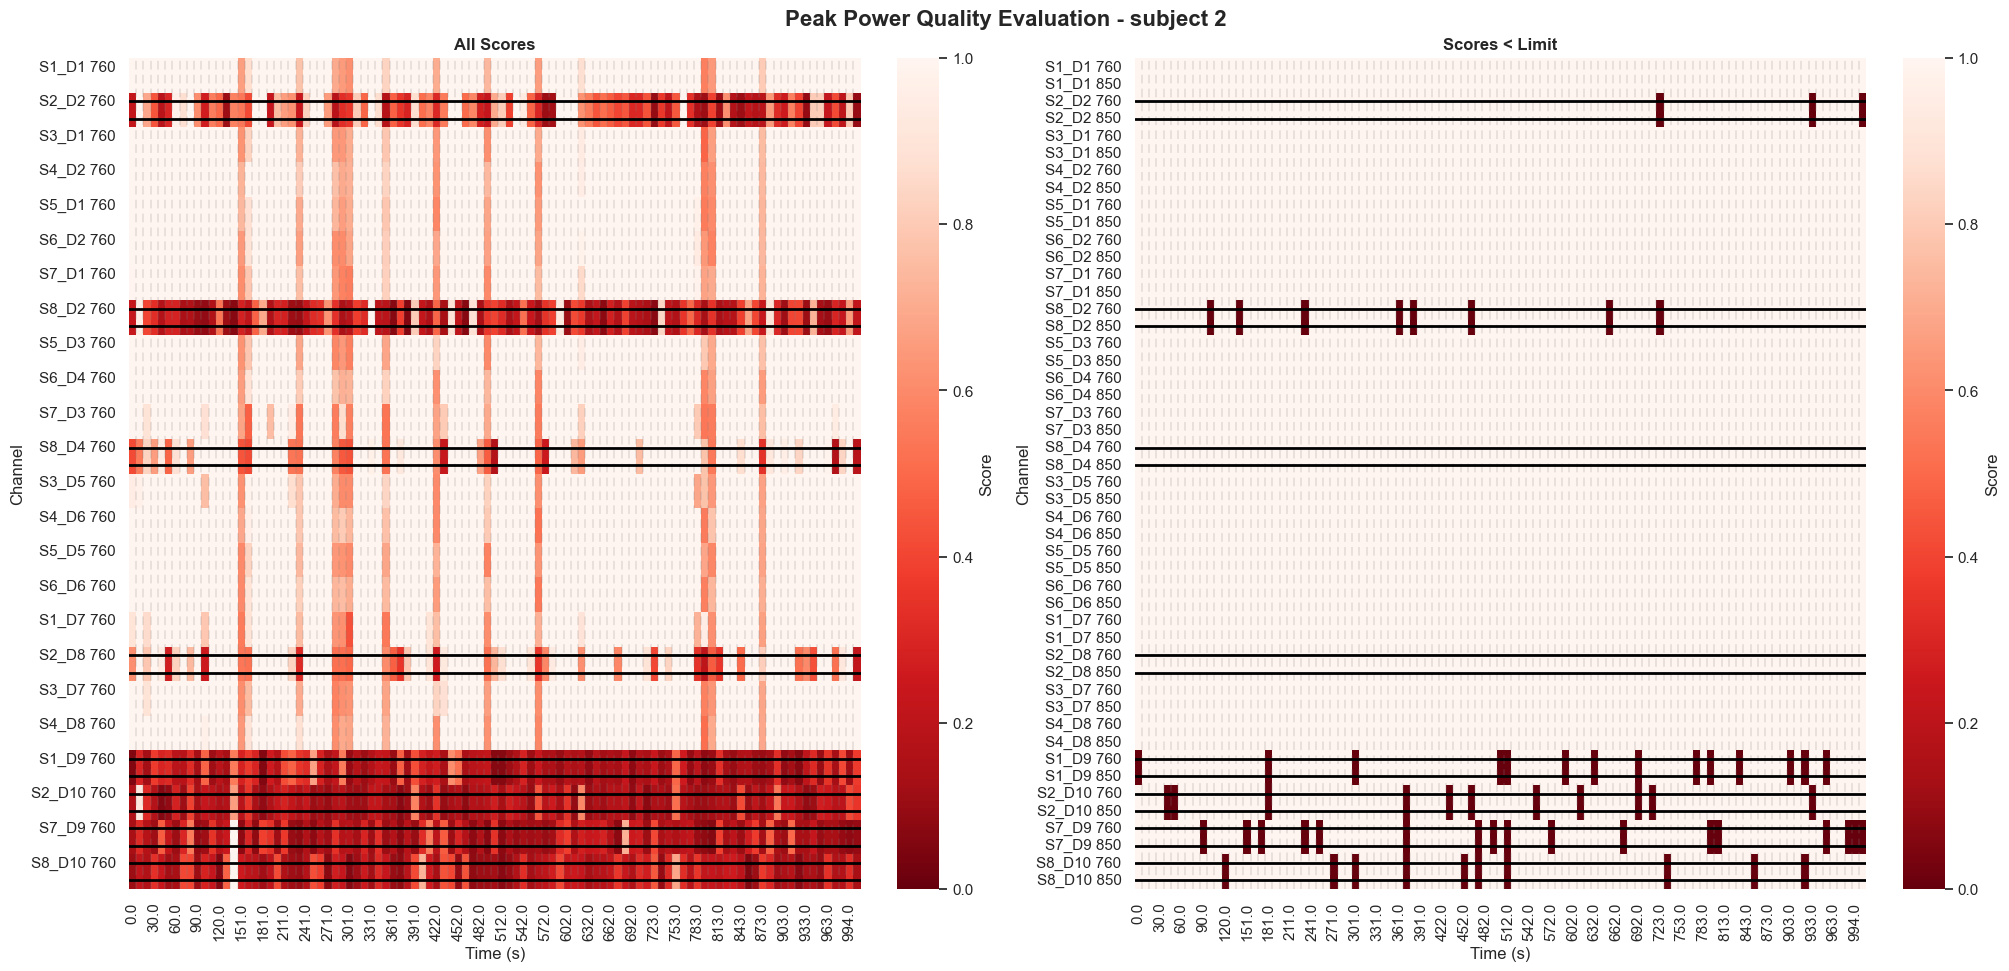

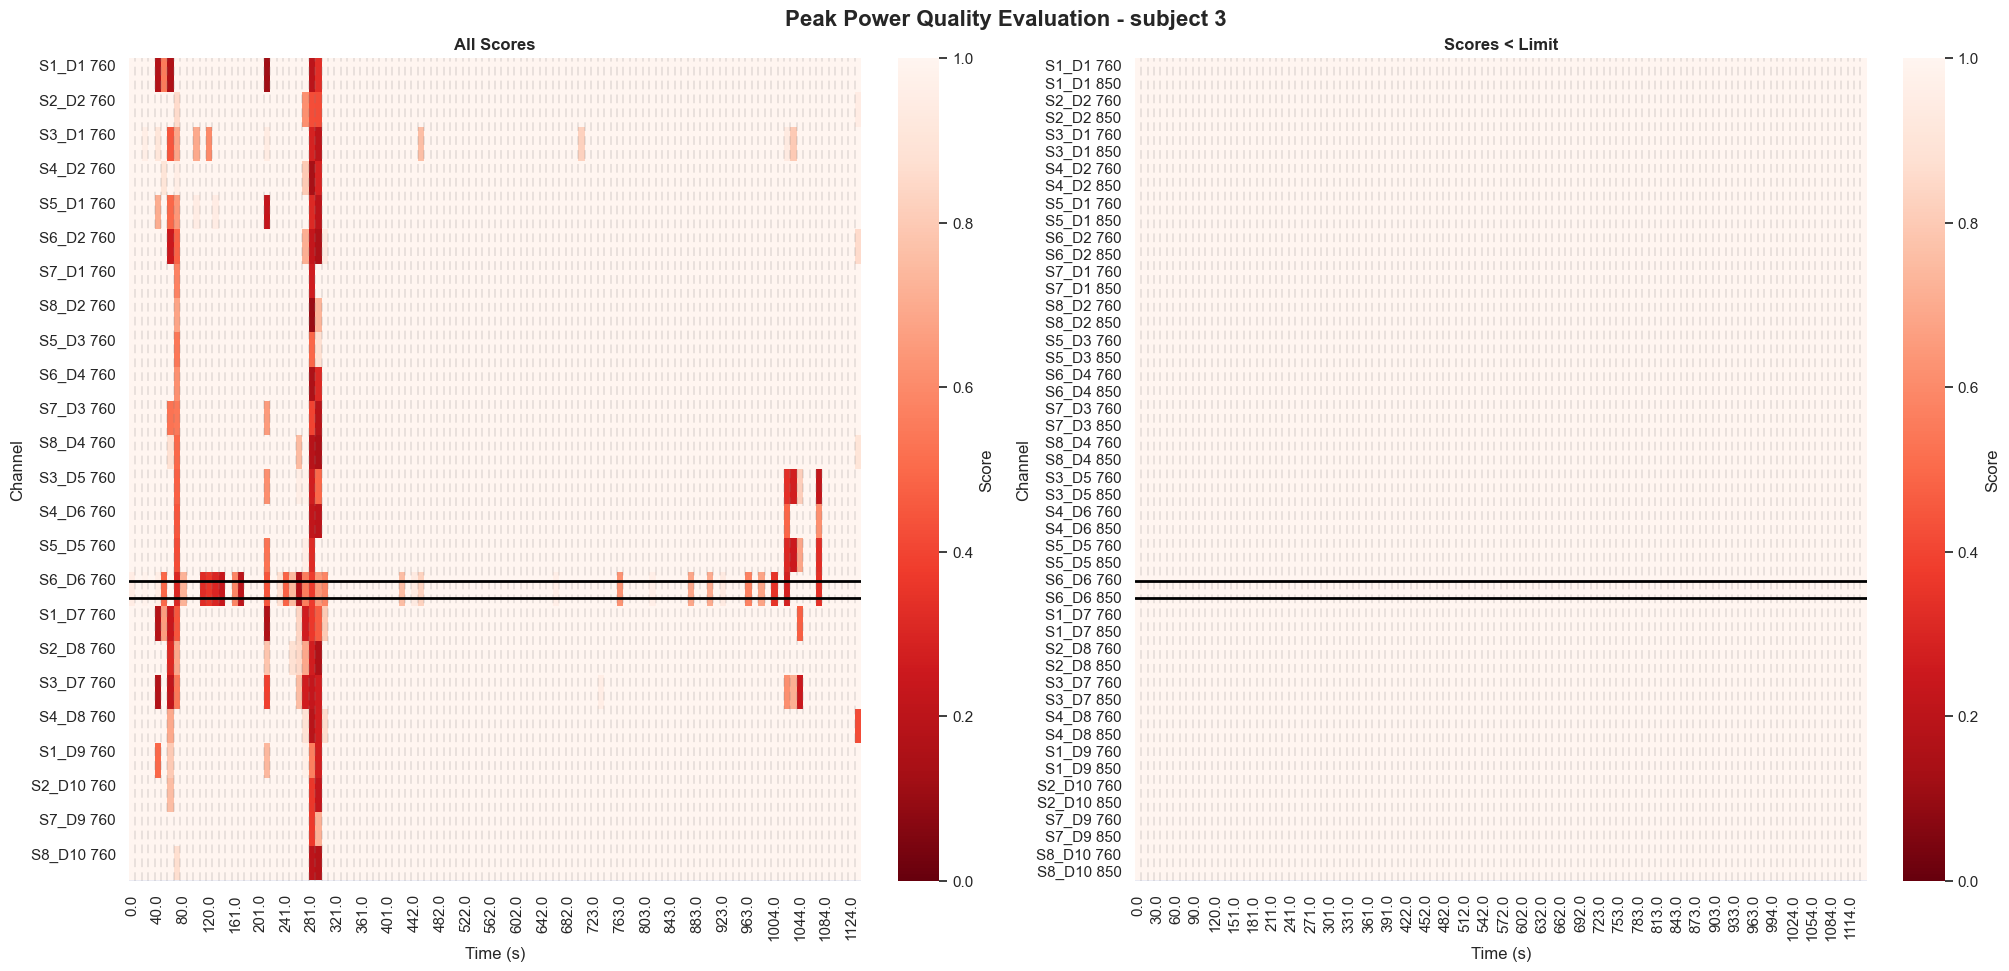

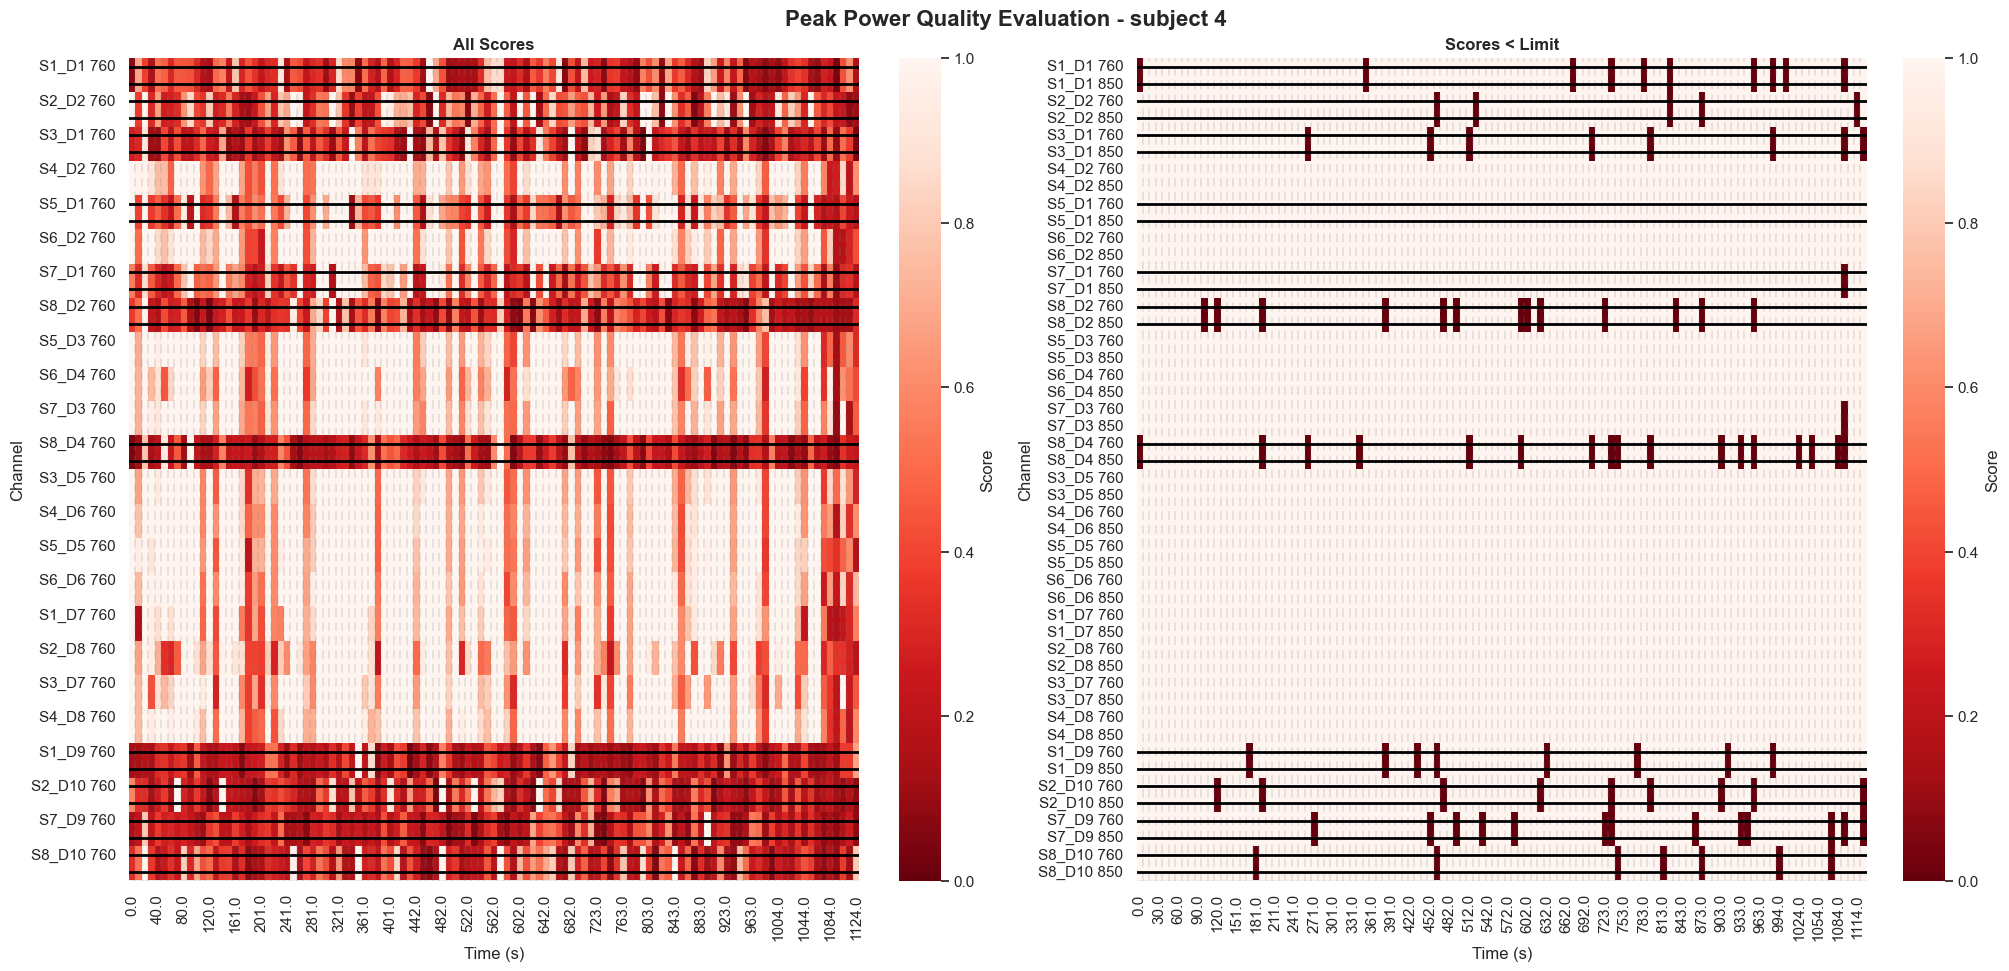

In [51]:
# View instances where a subset of channels may be contaminated by artifacts for a short duration of the recording
raw_od_SCI_PSPs = []
for sub in range(4):
    raw_od_SCI_PSP, scores, times = peak_power(raw_od_SCIs[sub], time_window=10)
    raw_od_SCI_PSPs.append(raw_od_SCI_PSP)

    # Plot
    %matplotlib inline
    plot_timechannel_quality_metric(raw_od_SCI_PSP, scores, times, threshold=0.1, title="Peak Power Quality Evaluation - subject " + str(sub+1) ) #see PHOEBE
    plt.show()

###### Subject 1

In [52]:
# Check that PP was indicated where the bad segments of data are
if plot:
    %matplotlib qt
    raw_od_SCI_PSPs[0].plot(duration=100, show_scrollbars = True, clipping = None);

###### Subject 2

In [53]:
# Check that PP was indicated where the bad segments of data are
if plot:
    %matplotlib qt
    raw_od_SCI_PSPs[1].plot(duration=100, show_scrollbars = True, clipping = None);

Channels marked as bad:
['S3_D1 760', 'S3_D1 850', 'S7_D1 760', 'S7_D1 850', 'S6_D4 760', 'S6_D4 850', 'S7_D3 760', 'S7_D3 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S7_D9 760', 'S7_D9 850']


###### Subject 3

In [54]:
# Check that PP was indicated where the bad segments of data are
if plot:
    %matplotlib qt
    raw_od_SCI_PSPs[2].plot(duration=100, show_scrollbars = True, clipping = None);

Channels marked as bad:
['S2_D2 760', 'S2_D2 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']


###### Subject 4

In [55]:
# Check that PP was indicated where the bad segments of data are
if plot:
    %matplotlib qt
    raw_od_SCI_PSPs[3].plot(duration=100, show_scrollbars = True, clipping = None);

Channels marked as bad:
['S6_D6 760', 'S6_D6 850']


---
> *Remark:*
- All segments with a PSP value under 0.1 were located in channels that were already indicated by the SCI method as bad channels
- No extra segments will be removed from the analysis
---